In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from tqdm import tqdm
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

#### New gates

In [25]:
new_fluos = pd.read_csv('datasets/experiment/028-A65-A191-repeat/fluos-lower-2.csv', index_col='time')
new_gates = ['e16x30SspGyrB', 'e32x33NrdJ1']

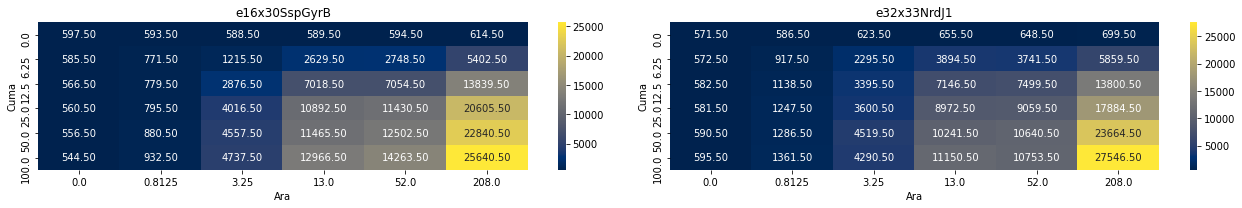

In [26]:
plot_heatmap(new_fluos.iloc[24], new_gates, 1, 2, cumas, aras)

In [28]:
new_gfp = new_fluos[filter(lambda x: x.startswith('positive-control-amp'), new_fluos.columns)].mean(axis=1)
new_neg_amp = new_fluos[filter(lambda x: x.startswith('negative-control-amp'), new_fluos.columns)].mean(axis=1)
new_neg_kan = new_fluos[filter(lambda x: x.startswith('negative-control-kan'), new_fluos.columns)].mean(axis=1)

In [30]:
idx = 3 * 8
new_fluos_rpu = []
for i in range(len(new_gates)):
    new_fluos_rpu.append(np.abs((new_fluos[filter(lambda x: x.startswith('{}'.format(new_gates[i])), new_fluos.columns)].iloc[idx] - new_neg_kan.iloc[idx]) / (new_gfp.iloc[idx] - new_neg_amp.iloc[idx])))
new_rpus = pd.concat(new_fluos_rpu)

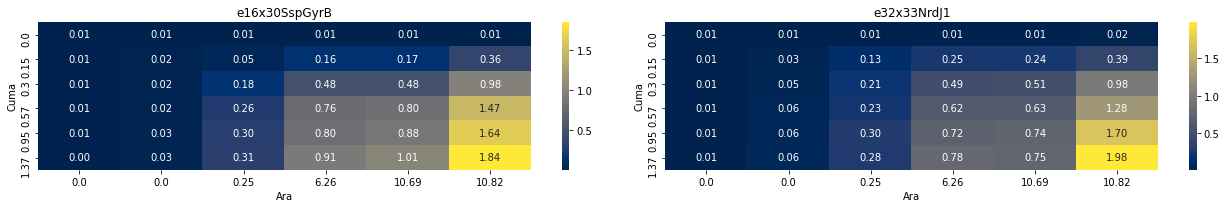

In [33]:
plot_heatmap(new_rpus, new_gates, 1, 2, np.round(cumas_rpu, 2), np.round(aras_rpu, 2))

100%|██████████| 30/30 [00:02<00:00, 10.52it/s]


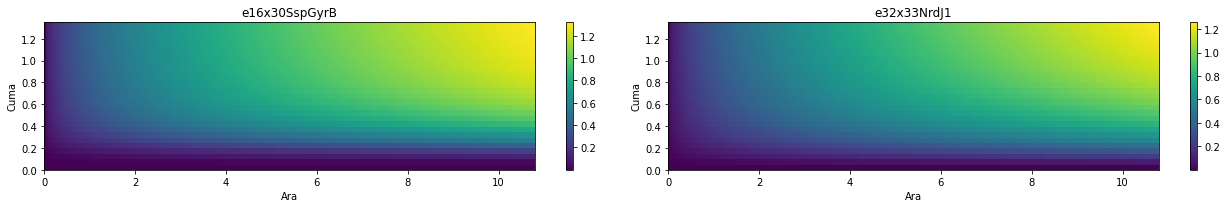

In [34]:
new_hill_params = plot_colormap(new_rpus, new_gates, 1, 2, np.round(cumas_rpu, 2), np.round(aras_rpu, 2))

In [35]:
new_hill_params

{'e16x30SspGyrB': array([2.98281945e-01, 1.72388881e+02, 2.11909646e+00, 5.50020573e-01,
        5.40857457e-03, 5.40857457e-03, 2.76557347e+00, 2.76557347e+00]),
 'e32x33NrdJ1': array([3.33691559e-01, 1.64615393e+02, 1.41440908e+00, 6.05984363e-01,
        7.78307072e-03, 7.78307072e-03, 2.97510077e+00, 2.97510077e+00])}

#### Import datasets

In [3]:
fluos = pd.read_csv('datasets/induction_matrix_and/induction_fluos.csv', index_col='time')
gates = ['e11x32STPhoRadA', 'e15x32NpuSspS2', 'e16x33NrdA2', 'e20x32gp411', 'e32x30SspGyrB',
         'e34x30MjaKlbA', 'e38x32gp418', 'e41x32NrdJ1', 'e42x32STIMPDH1']
cumas = [0, 6.25, 12.5, 25, 50, 100]
aras = [0, 0.8125, 3.25, 13, 52, 208]

In [4]:
def plot_heatmap(fluos, gates, num_row, num_col, row_lbl, col_lbl):
    
    f, axs = plt.subplots(num_row, num_col, sharex=False, sharey=False, figsize=(18, num_row*3))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(gates):
            gate = gates[i]
            fluo = fluos[filter(lambda x: x.startswith(gate), fluos.index)]
            
            fluo_t = fluo.reset_index().rename(columns={'index': 'gate'})
            fluo_t['ara'] = fluo_t['gate'].str[-2]
            fluo_t['cuma'] = fluo_t['gate'].str[-1]
            fluo_pvt = fluo_t.drop('gate', axis=1).pivot('cuma', 'ara')
            fluo_pvt.index = row_lbl
            fluo_pvt.columns = col_lbl
            
            sns.heatmap(fluo_pvt, annot=True, fmt='.2f', ax=ax, cmap='cividis')
            ax.set_xlabel('Ara')
            ax.set_ylabel('Cuma')
            ax.set_title(gate)
        else:
            ax.set_visible(False)
    plt.tight_layout()
    plt.show()

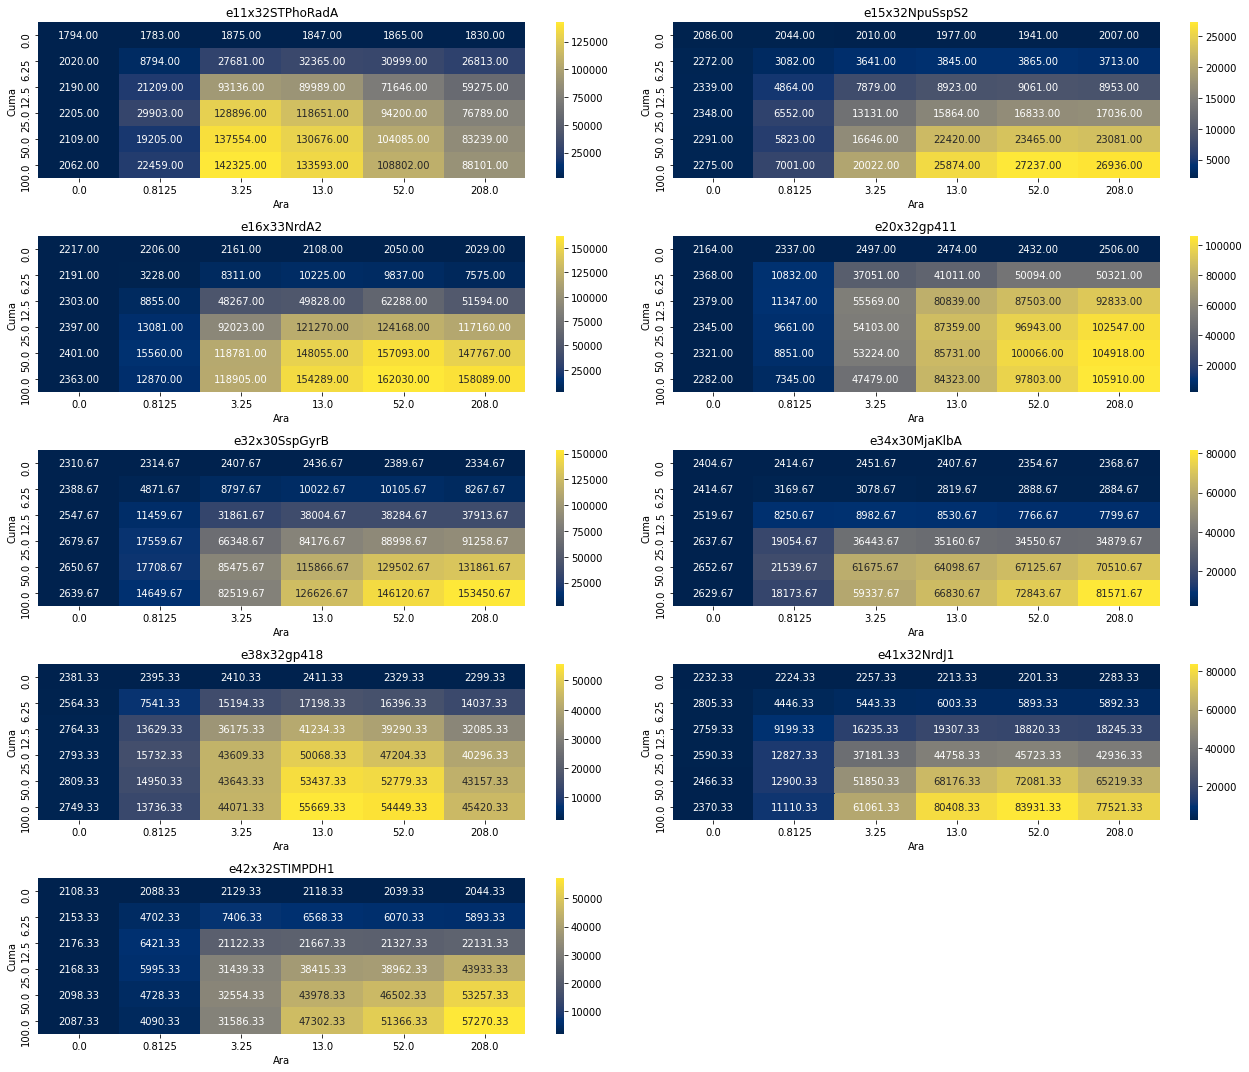

In [5]:
plot_heatmap(fluos.iloc[24], gates, 5, 2, cumas, aras)

#### Generate RPU

In [6]:
gfp, neg_amp, neg_kan = [], [], []
for i in range(1, 6): # because there are 5 plates
    #print(fluos[filter(lambda x: x.startswith('positive_control_4AE_{}'.format(i)), fluos.columns)].mean(axis=1))
    gfp.append(fluos[filter(lambda x: x.startswith('positive_control_4AE_{}'.format(i)), fluos.columns)].mean(axis=1))
    neg_amp.append(fluos[filter(lambda x: x.startswith('negative_control_4AE_{}'.format(i)), fluos.columns)].mean(axis=1))
    neg_kan.append(fluos[filter(lambda x: x.startswith('negative_control_3K3_{}'.format(i)), fluos.columns)].mean(axis=1))

In [7]:
idx = 3 * 8
fluos_rpu = []
for i in range(len(gates)):
    fluos_rpu.append(np.abs((fluos[filter(lambda x: x.startswith('{}'.format(gates[i])), fluos.columns)].iloc[idx] - neg_kan[int(i/2)].iloc[idx]) / (gfp[int(i/2)].iloc[idx] - neg_amp[int(i/2)].iloc[idx])))
rpus = pd.concat(fluos_rpu)

In [9]:
#cumas_rpu = [0.008406122909455404, 0.01691033499518672, 0.0419429064630855, 0.13469857887527883, 0.41592994783178494, 0.9254681484868258]
aras_rpu = [3.2872421314081804e-15, 0.00434816732064938, 0.24818419739411732, 6.256329570408148, 10.686683759188524, 10.81787045340335]
#aras_rpu = [0.047939271361185865, 6.176181163335466, 16.23080022197073, 16.87552797718598, 16.891198083491762, 16.89156436110603]
cumas_rpu = [5.160308727625551e-22, 0.1503530957891216, 0.30298032564481925, 0.5678111055145855, 0.9488899036690079, 1.371938809116961]
#aras_rpu = [0.018662727197652017, 3.178003346532333, 12.947615590104748, 16.501814366047896, 16.823954625777105, 16.846887772258317]

In [10]:
cumas_rpu = [2.1140508404516445e-16, 0.013913767421852795, 0.04708753302668632, 0.1481921474634383, 0.38432925220642106, 0.706446628596465]
aras_rpu = [1.0957813643749393e-17, 1.2106667891676, 4.633309896886311, 7.370992838892073, 7.99133502045251, 8.080680676620355]

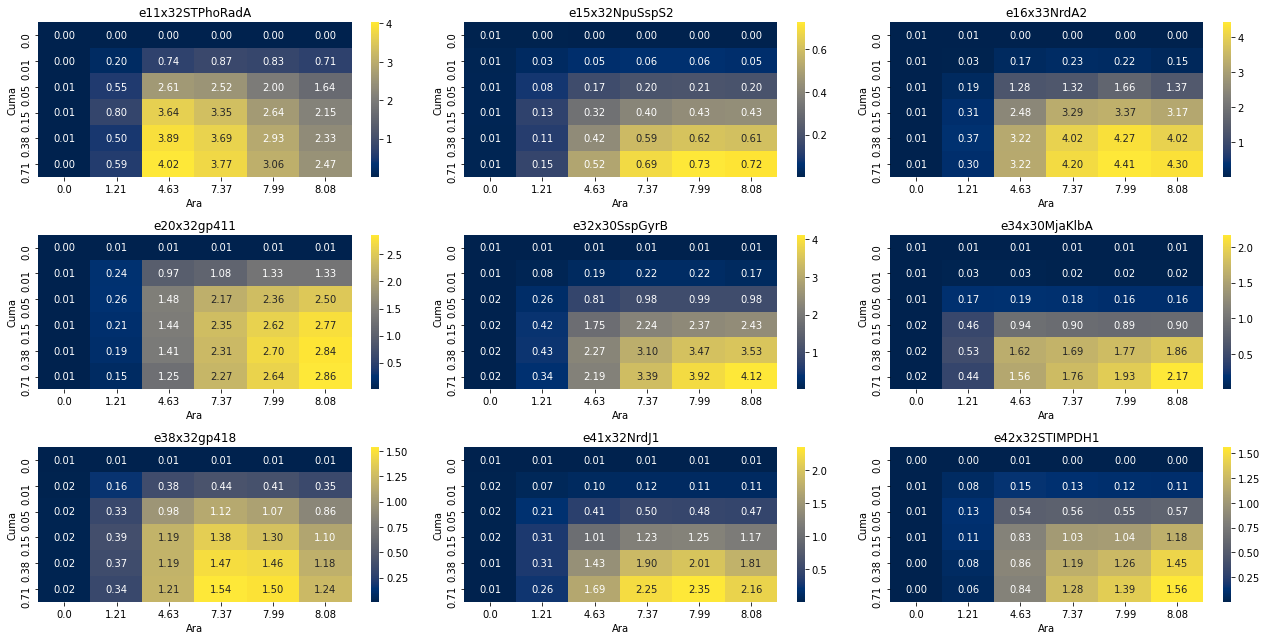

In [11]:
plot_heatmap(rpus, gates, 3, 3, np.round(cumas_rpu, 2), np.round(aras_rpu, 2))

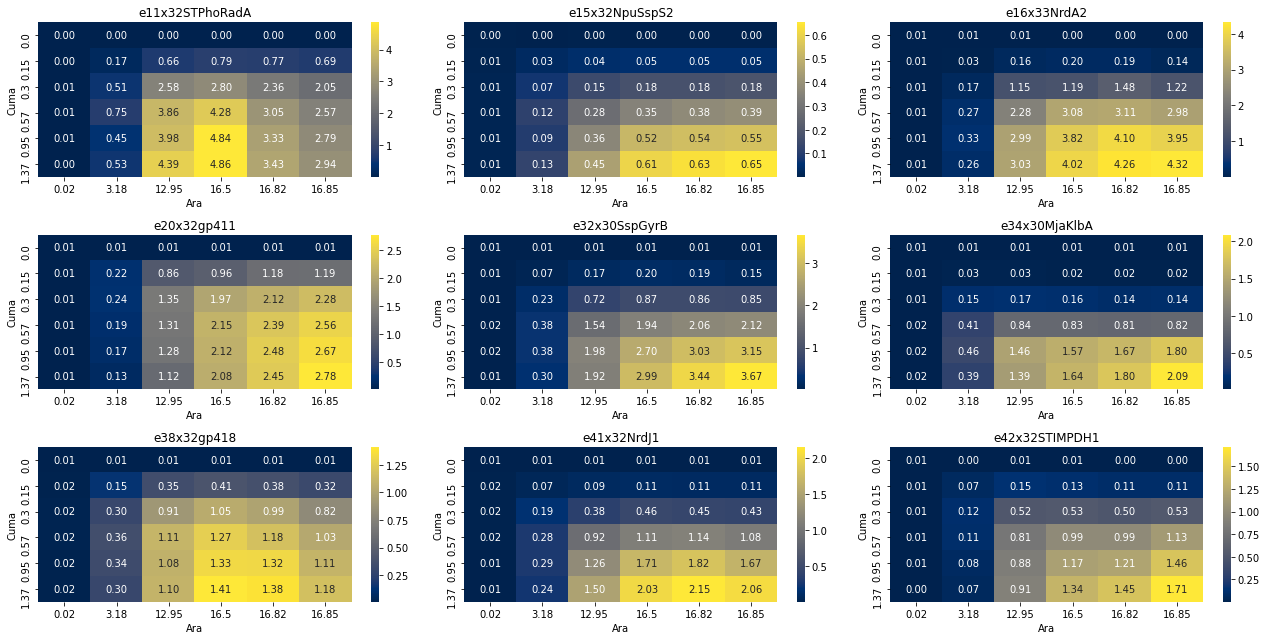

In [62]:
plot_heatmap(rpus, gates, 3, 3, np.round(cumas_rpu, 2), np.round(aras_rpu, 2))

#### Static Models

In [12]:
#objective function
def computeSSE(ts, data, p0, bounds, func):
    
    popt, _ = curve_fit(func, ts, data, p0=p0, bounds=bounds)
    sim = hill_activation_and(ts, *popt)
    
    return sum([(act - pred)**2 for act, pred in zip(data, sim)])

#generate random numbers from a uniform distribution for the initial guesses
def randomSearch(iterations, ts, data, bounds, func):
    
    init_guess = []
    for k in tqdm(range(iterations)):
        p0 = [np.random.uniform(low=low, high=high) for low, high in zip(bounds[0], bounds[1])]
        error = computeSSE(ts, data, p0, bounds, func)
        init_guess.append((error, p0))
    return sorted(init_guess)[0][1]

In [13]:
#complete
def hill_activation(x, K, n, ymin, ymax):
    
    return ymin + (ymax - ymin) * (x**n / (K**n + x**n))

def hill_activation_and(x, K1, K2, n1, n2, ymin1, ymin2, ymax1, ymax2):
    
    x1, x2 = x
    return hill_activation(x1, K1, n1, ymin1, ymax1) * hill_activation(x2, K2, n2, ymin2, ymax2)

100%|██████████| 30/30 [00:02<00:00, 11.83it/s]


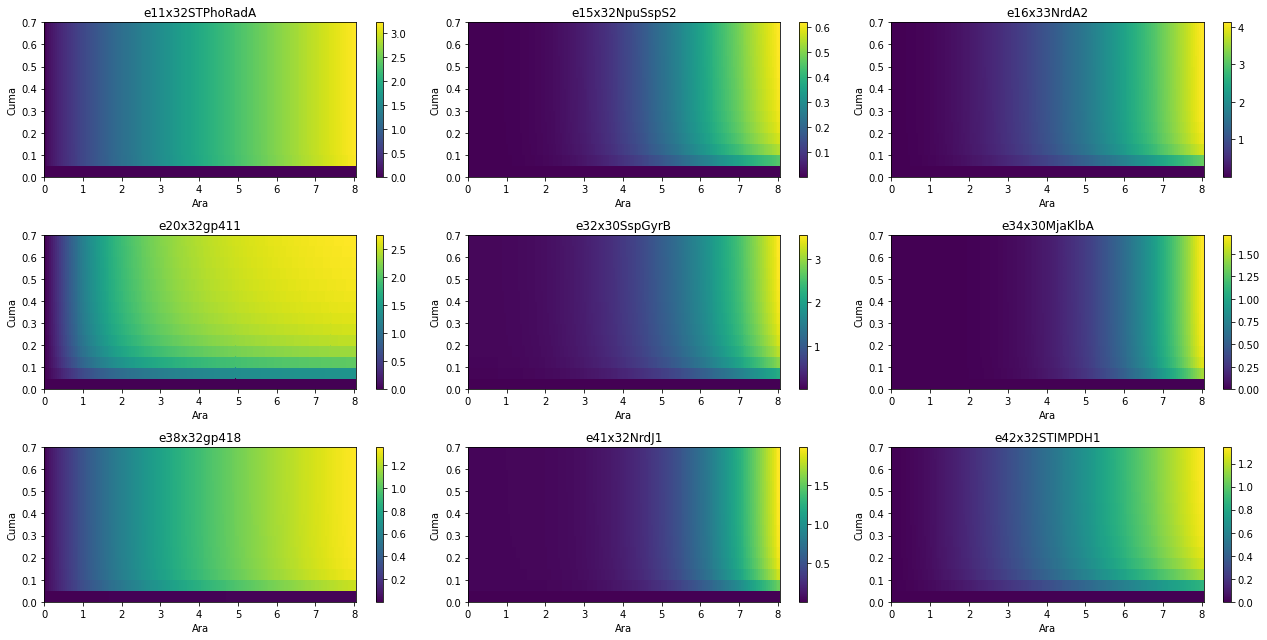

In [14]:
def plot_colormap(fluos, gates, num_row, num_col, ind1, ind2):
    
    hill_params = {}
    f, axs = plt.subplots(num_row, num_col, sharex=False, sharey=False, figsize=(18, num_row*3))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(gates):
            gate = gates[i]
            fluo = fluos[filter(lambda x: x.startswith(gate), fluos.index)]
            #fluo_t = fluo.reset_index().rename(columns={'index': 'gate'})
            #fluo_t['cuma'] = fluo_t['gate'].str[-2]
            #fluo_t['ara'] = fluo_t['gate'].str[-1]
            #fluo_pvt = fluo_t.drop('gate', axis=1).pivot('cuma', 'ara')
            #fluo_pvt.index = row_lbl
            #fluo_pvt.columns = col_lbl
            #sns.heatmap(fluo_pvt, annot=True, fmt='.2f', ax=ax, cmap='cividis')
            
            #print(fluo_t[])
            #break
            
            x1, x2 = np.meshgrid(ind1, ind2)
            x = np.vstack((x1.ravel(), x2.ravel()))
            y = fluo.values
            #init_guess = [10, 10, 1, 1, y.min(), y.min(), y.max(), y.max()]
            gate_bounds = [[0, 0, 0, 0, 0, 0, 0, 0],
                           [1e3, 1e3, 4, 4, y.min()+0.2*y.min(), y.min()+0.2*y.min(), y.max()+0.5*y.max(), y.max()+0.5*y.max()]]
            init_guess = randomSearch(30, x, y, gate_bounds, hill_activation_and)
            popt, pcov = curve_fit(hill_activation_and, x, y, p0=init_guess, bounds=gate_bounds)
            
            y_pred = hill_activation_and(x, *popt)
            #print(gate, popt, r2_score(y, y_pred))
            hill_params[gate] = popt
            
            arr_ind1 = np.arange(0, np.max(ind1), 0.05)
            arr_ind2 = np.arange(0, np.max(ind2), 0.05)
            x1_, x2_ = np.meshgrid(arr_ind1, arr_ind2)
            x_ = np.vstack((x1_.ravel(), x2_.ravel()))
            y_pred_ = hill_activation_and(x_, *popt)
            
            cf = ax.pcolormesh(x2_, x1_, y_pred_.reshape(-1, len(arr_ind1)), cmap='viridis')
            f.colorbar(cf, ax=ax)
            
            #sns.heatmap(y_pred_.reshape(-1, len(arr_ind1)), ax=ax)
            
            #plt.clim(0, 5)
            #ax.axvline(h, color='red')
            #ax.axhline(h, color='red')
            
            #ax.axvline(0.01866272721909743, color='red')
            #ax.axvline(1.365845205649679e-12, color='red')
            #ax.axvline(3.575023694350424e-27, color='red')
            #ax.axvline(2.9144583244448006e-14, color='red')
            #ax.axvline(1.302244740421529, color='red')
            #ax.axvline(1.8474063001429318e-17, color='red')
            #ax.axvline(0.1215231788079449, color='red')
            
            #ax.set_xlim([0, 2])
            #ax.set_ylim([0, 0.5])
            
            ax.set_xlabel('Ara')
            ax.set_ylabel('Cuma')
            ax.set_title(gate)
        else:
            ax.set_visible(False)
    plt.tight_layout()
    plt.show()
    
    return hill_params

hill_params = plot_colormap(rpus, gates, 3, 3, np.round(cumas_rpu, 2), np.round(aras_rpu, 2))

In [16]:
hill_params

{'e11x32STPhoRadA': array([1.38609966e-02, 1.60895892e+02, 4.00000000e+00, 7.77066640e-01,
        8.47975638e-38, 1.40958159e-04, 6.03613733e+00, 6.03613733e+00]),
 'e15x32NpuSspS2': array([2.51938785e-02, 7.73416012e+00, 1.39580084e+00, 3.28358067e+00,
        1.21508540e-03, 1.21508540e-03, 1.08890566e+00, 1.08890566e+00]),
 'e16x33NrdA2': array([2.95748723e-02, 2.41023864e+01, 2.20839441e+00, 2.05342677e+00,
        1.03610762e-03, 1.03610762e-03, 6.61478933e+00, 6.61478933e+00]),
 'e20x32gp411': array([4.92310594e-02, 1.37152945e+00, 1.43643677e+00, 1.37682288e+00,
        2.13397217e-39, 5.50018830e-03, 2.83428427e+00, 1.08094260e+00]),
 'e32x30SspGyrB': array([3.74641327e-02, 1.77964343e+01, 1.45395085e+00, 2.84911799e+00,
        1.20825150e-03, 1.03106627e-02, 6.18377096e+00, 6.18377096e+00]),
 'e34x30MjaKlbA': array([1.67520247e-02, 1.20550643e+01, 1.64259675e+00, 4.00000000e+00,
        1.17478406e-02, 1.01340517e-28, 3.24902918e+00, 3.24902918e+00]),
 'e38x32gp418': array([

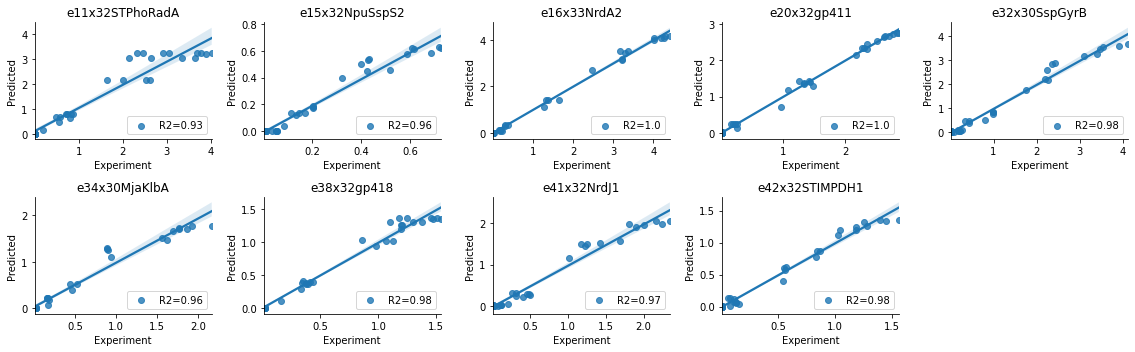

In [17]:
def plot_prediction(fluos, gates, row, col, hill_params, cumas, aras):
    
    x1, x2 = np.meshgrid(cumas, aras)
    x = np.vstack((x1.ravel(), x2.ravel()))
    
    f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(16, 5))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(gates):
            gate = gates[i]
            popt = hill_params[gate]
            fluo = fluos[filter(lambda x: x.startswith(gate), fluos.index)]
            y = fluo.values
            
            pred = hill_activation_and(x, *popt)
            sns.regplot(y, pred, ax=ax, label='R2={}'.format(round(r2_score(y, pred), 2)))
            ax.set_title(gates[i])
            ax.set_xlabel('Experiment')
            ax.set_ylabel('Predicted')
            ax.legend(loc=4)
            sns.despine()
        else:
            ax.set_visible(False)
    plt.tight_layout()
    
plot_prediction(rpus, gates, 2, 5, hill_params, np.round(cumas_rpu, 2), np.round(aras_rpu, 2))

### No regulators

In [18]:
cumas_rpu = [4.351624888479863e-17, 0.12836646443345376, 0.4554069181682603, 1.4320915855505334, 3.36251583462493, 5.260842521395112]
aras_rpu = [0.039068156451732144, 4.874070477308016, 13.399205481456802, 14.060790558956999, 14.079395648916492, 14.07989419214939]

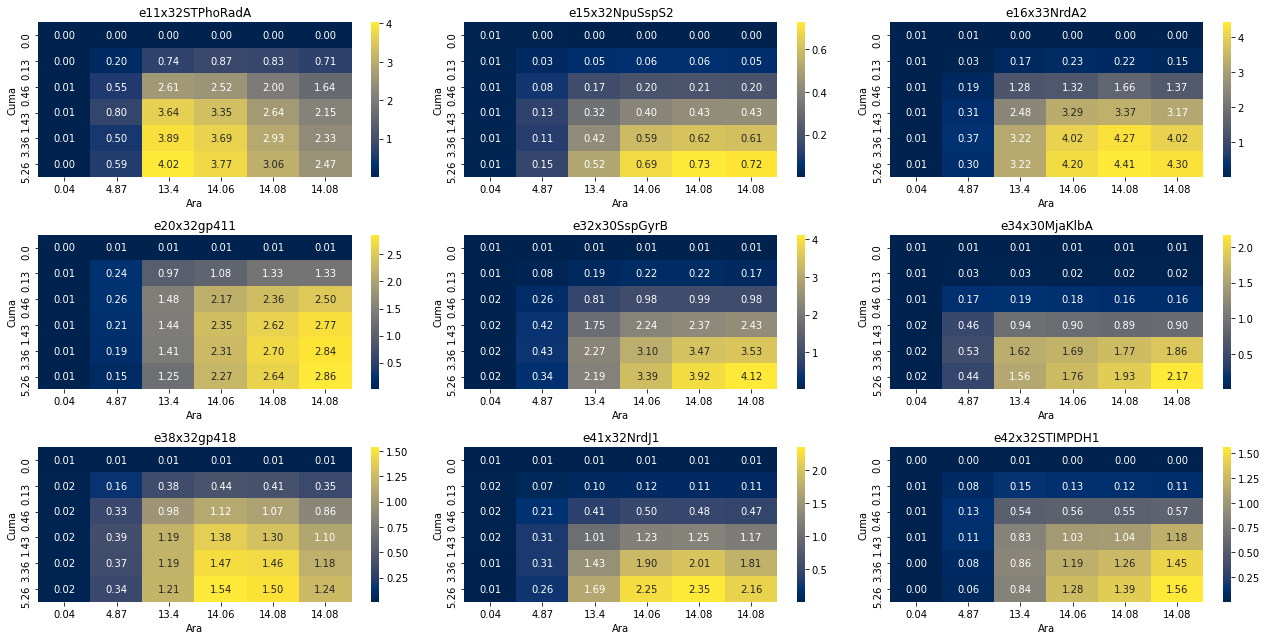

In [19]:
plot_heatmap(rpus, gates, 3, 3, np.round(cumas_rpu, 2), np.round(aras_rpu, 2))

100%|██████████| 30/30 [00:02<00:00, 13.10it/s]


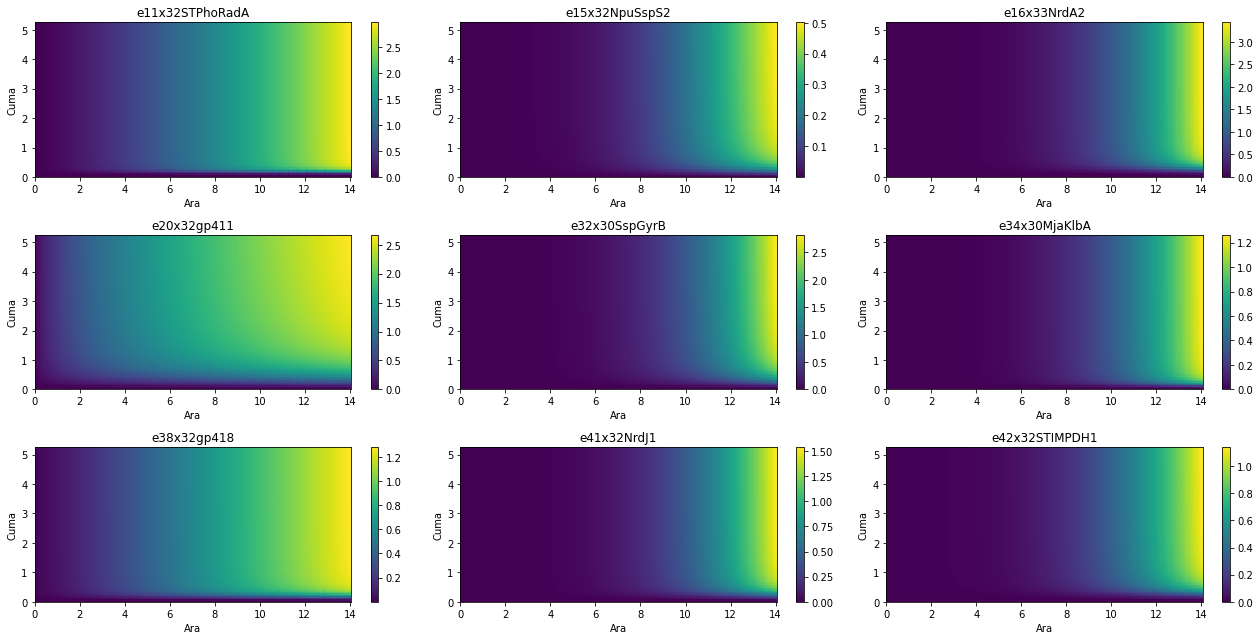

In [20]:
hill_params = plot_colormap(rpus, gates, 3, 3, np.round(cumas_rpu, 2), np.round(aras_rpu, 2))

In [21]:
hill_params

{'e11x32STPhoRadA': array([1.74873742e-01, 7.41241992e+01, 4.00000000e+00, 1.45453116e+00,
        1.03476378e-22, 1.05460242e-03, 6.03613733e+00, 6.03613733e+00]),
 'e15x32NpuSspS2': array([2.53721550e-01, 1.51091600e+01, 1.74644357e+00, 4.00000000e+00,
        1.21508540e-03, 1.21508540e-03, 1.08890566e+00, 1.08890566e+00]),
 'e16x33NrdA2': array([2.98434694e-01, 2.59140267e+01, 2.80238385e+00, 4.00000000e+00,
        1.03610762e-03, 2.24346525e-23, 6.61478933e+00, 6.61478933e+00]),
 'e20x32gp411': array([4.58937590e-01, 1.47212232e+02, 1.66063994e+00, 7.30522489e-01,
        3.03991307e-39, 2.81818359e-38, 4.22443515e+00, 4.23320195e+00]),
 'e32x30SspGyrB': array([3.44971166e-01, 2.62988191e+01, 1.81316178e+00, 4.00000000e+00,
        1.62894513e-11, 4.60537783e-36, 6.18377096e+00, 6.18377096e+00]),
 'e34x30MjaKlbA': array([1.79060302e-01, 2.30494084e+01, 2.20829944e+00, 4.00000000e+00,
        1.17478406e-02, 3.71720042e-22, 3.24902918e+00, 3.24902918e+00]),
 'e38x32gp418': array([

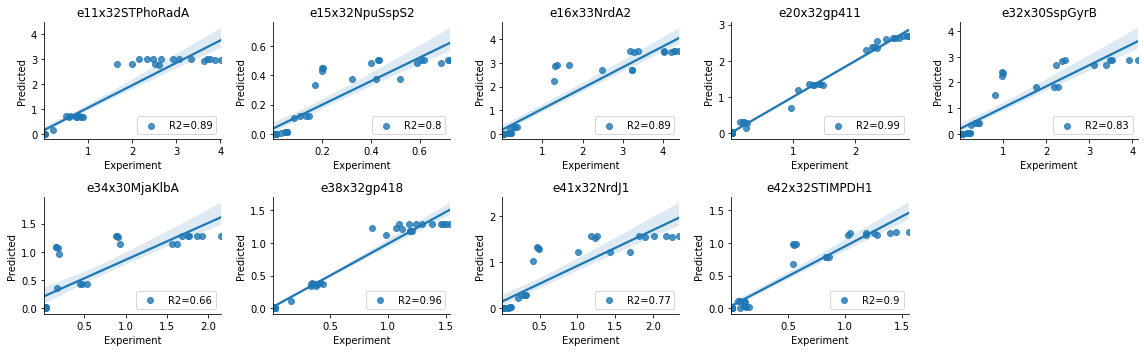

In [22]:
plot_prediction(rpus, gates, 2, 5, hill_params, np.round(cumas_rpu, 2), np.round(aras_rpu, 2))

0.931130133098649


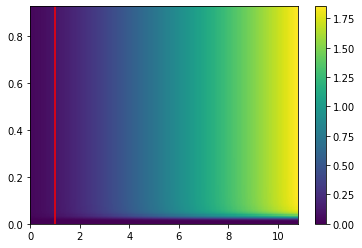

In [98]:
arr_ind1 = np.arange(0, np.max(cumas_rpu), 0.005)
arr_ind2 = np.arange(0, np.max(aras_rpu), 0.05)
x1_, x2_ = np.meshgrid(arr_ind1, arr_ind2)
x_ = np.vstack((x1_.ravel(), x2_.ravel()))
y_pred = hill_activation_and(x_, *hill_params['e34x30MjaKlbA'])
cf = plt.pcolormesh(x2_, x1_, y_pred.reshape(-1, len(arr_ind1)), cmap='viridis')
plt.colorbar(cf)

half_point = y_pred.max()/2
y_err = [np.abs(i-half_point) for i in y_pred]
min_err = y_pred[y_err.index(min(y_err))]
idx = (np.where(y_pred.reshape(-1, len(arr_ind1))==min_err)[1][0])
plt.axvline(x2_[idx][0], color='red')
print(half_point)
plt.show()

In [96]:
x2_[5][0]

0.25

  7%|▋         | 2/30 [00:00<00:01, 19.13it/s]

e11x32STPhoRadA [2.36583131e-02 8.43810945e+01 4.00000000e+00 1.50078707e+00
 5.34425649e-42 1.05460242e-03 6.03613733e+00 6.03613733e+00] 0.8607637124948094


  3%|▎         | 1/30 [00:00<00:03,  9.11it/s]

e15x32NpuSspS2 [2.85929861e-02 1.83034207e+01 3.17307774e+00 4.00000000e+00
 9.04788669e-18 1.21508540e-03 1.08890566e+00 1.08890566e+00] 0.7929806088197844


  0%|          | 0/30 [00:00<?, ?it/s]

e16x33NrdA2 [3.11045760e-02 3.11571874e+01 4.00000000e+00 4.00000000e+00
 3.70826516e-41 2.86909313e-25 6.61478933e+00 6.61478933e+00] 0.8726141619980341


  0%|          | 0/30 [00:00<?, ?it/s]

e20x32gp411 [3.80499040e-02 1.85729782e+02 3.22106368e+00 7.59755575e-01
 1.39060970e-35 2.46258180e-38 4.29512074e+00 4.29512074e+00] 0.9844886547597128


  3%|▎         | 1/30 [00:00<00:03,  9.04it/s]

e32x30SspGyrB [3.32083288e-02 3.19164110e+01 3.54084693e+00 4.00000000e+00
 8.10814995e-16 2.64444371e-30 6.18377096e+00 6.18377096e+00] 0.8127378754983646


  7%|▋         | 2/30 [00:00<00:01, 14.36it/s]

e34x30MjaKlbA [2.37406114e-02 2.77754019e+01 4.00000000e+00 4.00000000e+00
 1.61859291e-21 1.55583417e-30 3.24902918e+00 3.24902918e+00] 0.6496059742054408


  3%|▎         | 1/30 [00:00<00:03,  8.72it/s]

e38x32gp418 [2.47967112e-02 3.76669784e+01 4.00000000e+00 1.43679508e+00
 6.90175469e-33 8.78079108e-03 2.30753701e+00 2.30753701e+00] 0.9606747800983446


  0%|          | 0/30 [00:00<?, ?it/s]

e41x32NrdJ1 [2.91794153e-02 2.75144592e+01 3.94312650e+00 4.00000000e+00
 5.60748998e-30 1.52822851e-24 3.52150568e+00 3.52150568e+00] 0.7615263017076066


100%|██████████| 30/30 [00:03<00:00,  8.71it/s]


e42x32STIMPDH1 [3.29881919e-02 2.36442915e+01 4.00000000e+00 4.00000000e+00
 8.35212885e-32 2.97909555e-03 2.34091743e+00 2.34091743e+00] 0.8917734902560747


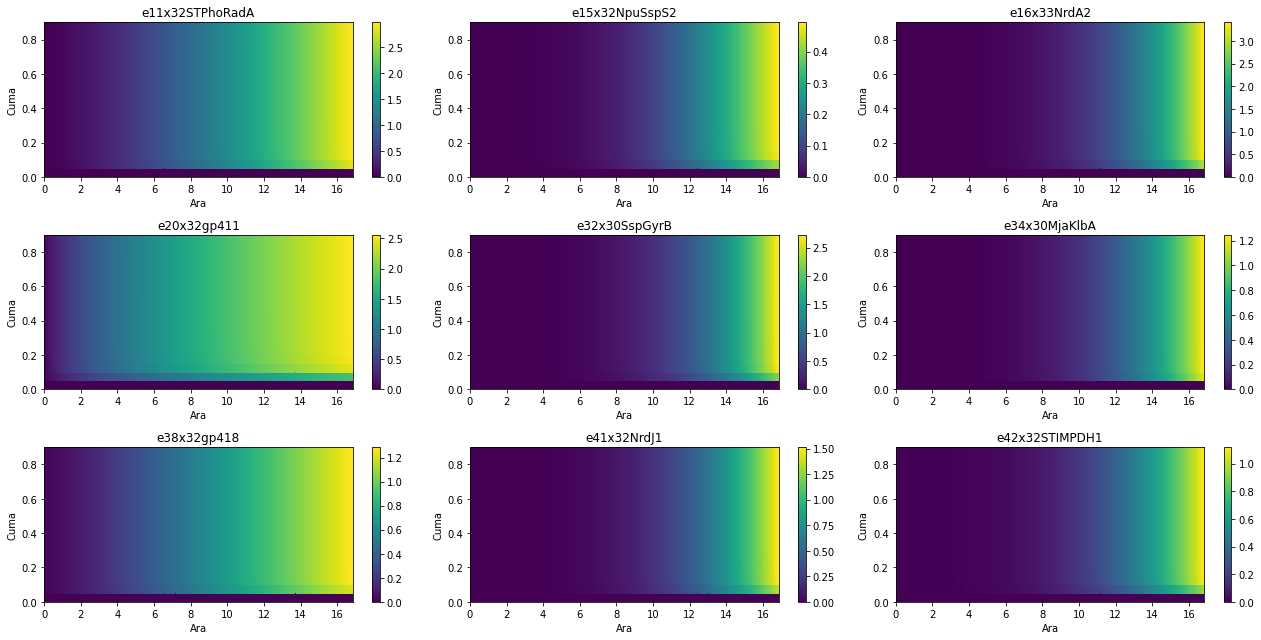

In [46]:
hill_params = plot_colormap(rpus, gates, 3, 3, np.round(cumas_rpu, 2), np.round(aras_rpu, 2))

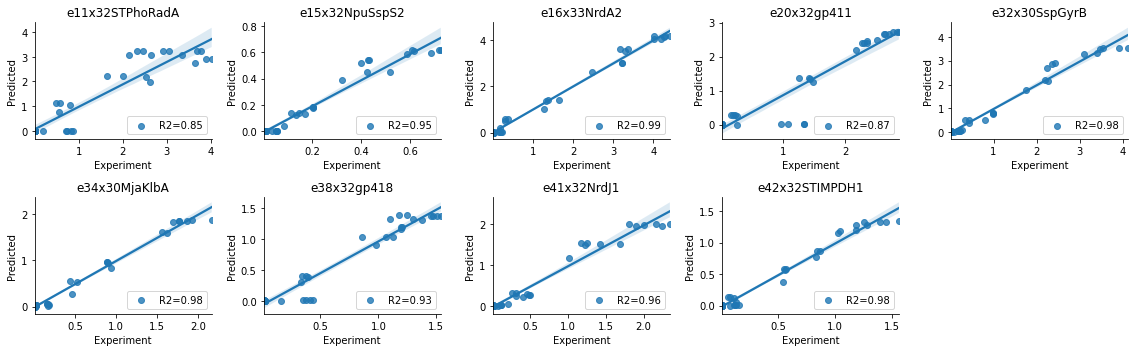

In [16]:
def plot_prediction(fluos, gates, row, col, hill_params, cumas, aras):
    
    x1, x2 = np.meshgrid(cumas, aras)
    x = np.vstack((x1.ravel(), x2.ravel()))
    
    f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(16, 5))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(gates):
            gate = gates[i]
            popt = hill_params[gate]
            fluo = fluos[filter(lambda x: x.startswith(gate), fluos.index)]
            y = fluo.values
            
            pred = hill_activation_and(x, *popt)
            sns.regplot(y, pred, ax=ax, label='R2={}'.format(round(r2_score(y, pred), 2)))
            ax.set_title(gates[i])
            ax.set_xlabel('Experiment')
            ax.set_ylabel('Predicted')
            ax.legend(loc=4)
            sns.despine()
        else:
            ax.set_visible(False)
    plt.tight_layout()
    
plot_prediction(rpus, gates, 2, 5, hill_params, np.round(cumas_rpu, 2), np.round(aras_rpu, 2))

#### Modeling a Single Gate

e11x32STPhoRadA [1.00000000e+00 4.61903689e+01 1.00000000e+00 1.24264136e+00
 6.58271567e-05 6.58271547e-05 5.82677024e+00 5.82677027e+00]
e15x32NpuSspS2 [1.00000000e+00 4.31811340e+00 1.00000000e+00 5.00000000e+00
 4.32578458e-04 2.26057479e-04 7.83945013e-01 7.83945013e-01]
e16x33NrdA2 [1.00000000e+00 2.00042563e+01 1.00000000e+00 5.00000000e+00
 1.97194788e-03 1.97194788e-03 5.18562536e+00 5.18562536e+00]
e20x32gp411 [1.00000000e+00 5.75626011e+00 1.00000000e+00 1.00000000e+00
 6.63951643e-47 6.35405428e-03 2.92437918e+00 2.24162243e+00]
e32x30SspGyrB [1.00000000e+00 1.98898429e+01 1.00000000e+00 5.00000000e+00
 9.49640288e-03 9.49640288e-03 4.40624314e+00 4.40624314e+00]
e34x30MjaKlbA [1.00000000e+00 1.71615282e+01 1.00000000e+00 5.00000000e+00
 1.07303987e-02 1.60662491e-14 2.50722595e+00 2.50722595e+00]
e38x32gp418 [1.         5.67659974 1.         1.81776222 0.0108867  0.0108867
 1.691971   1.691971  ]
e41x32NrdJ1 [1.00000000e+00 1.67517917e+01 1.00000000e+00 5.00000000e+00
 7.6

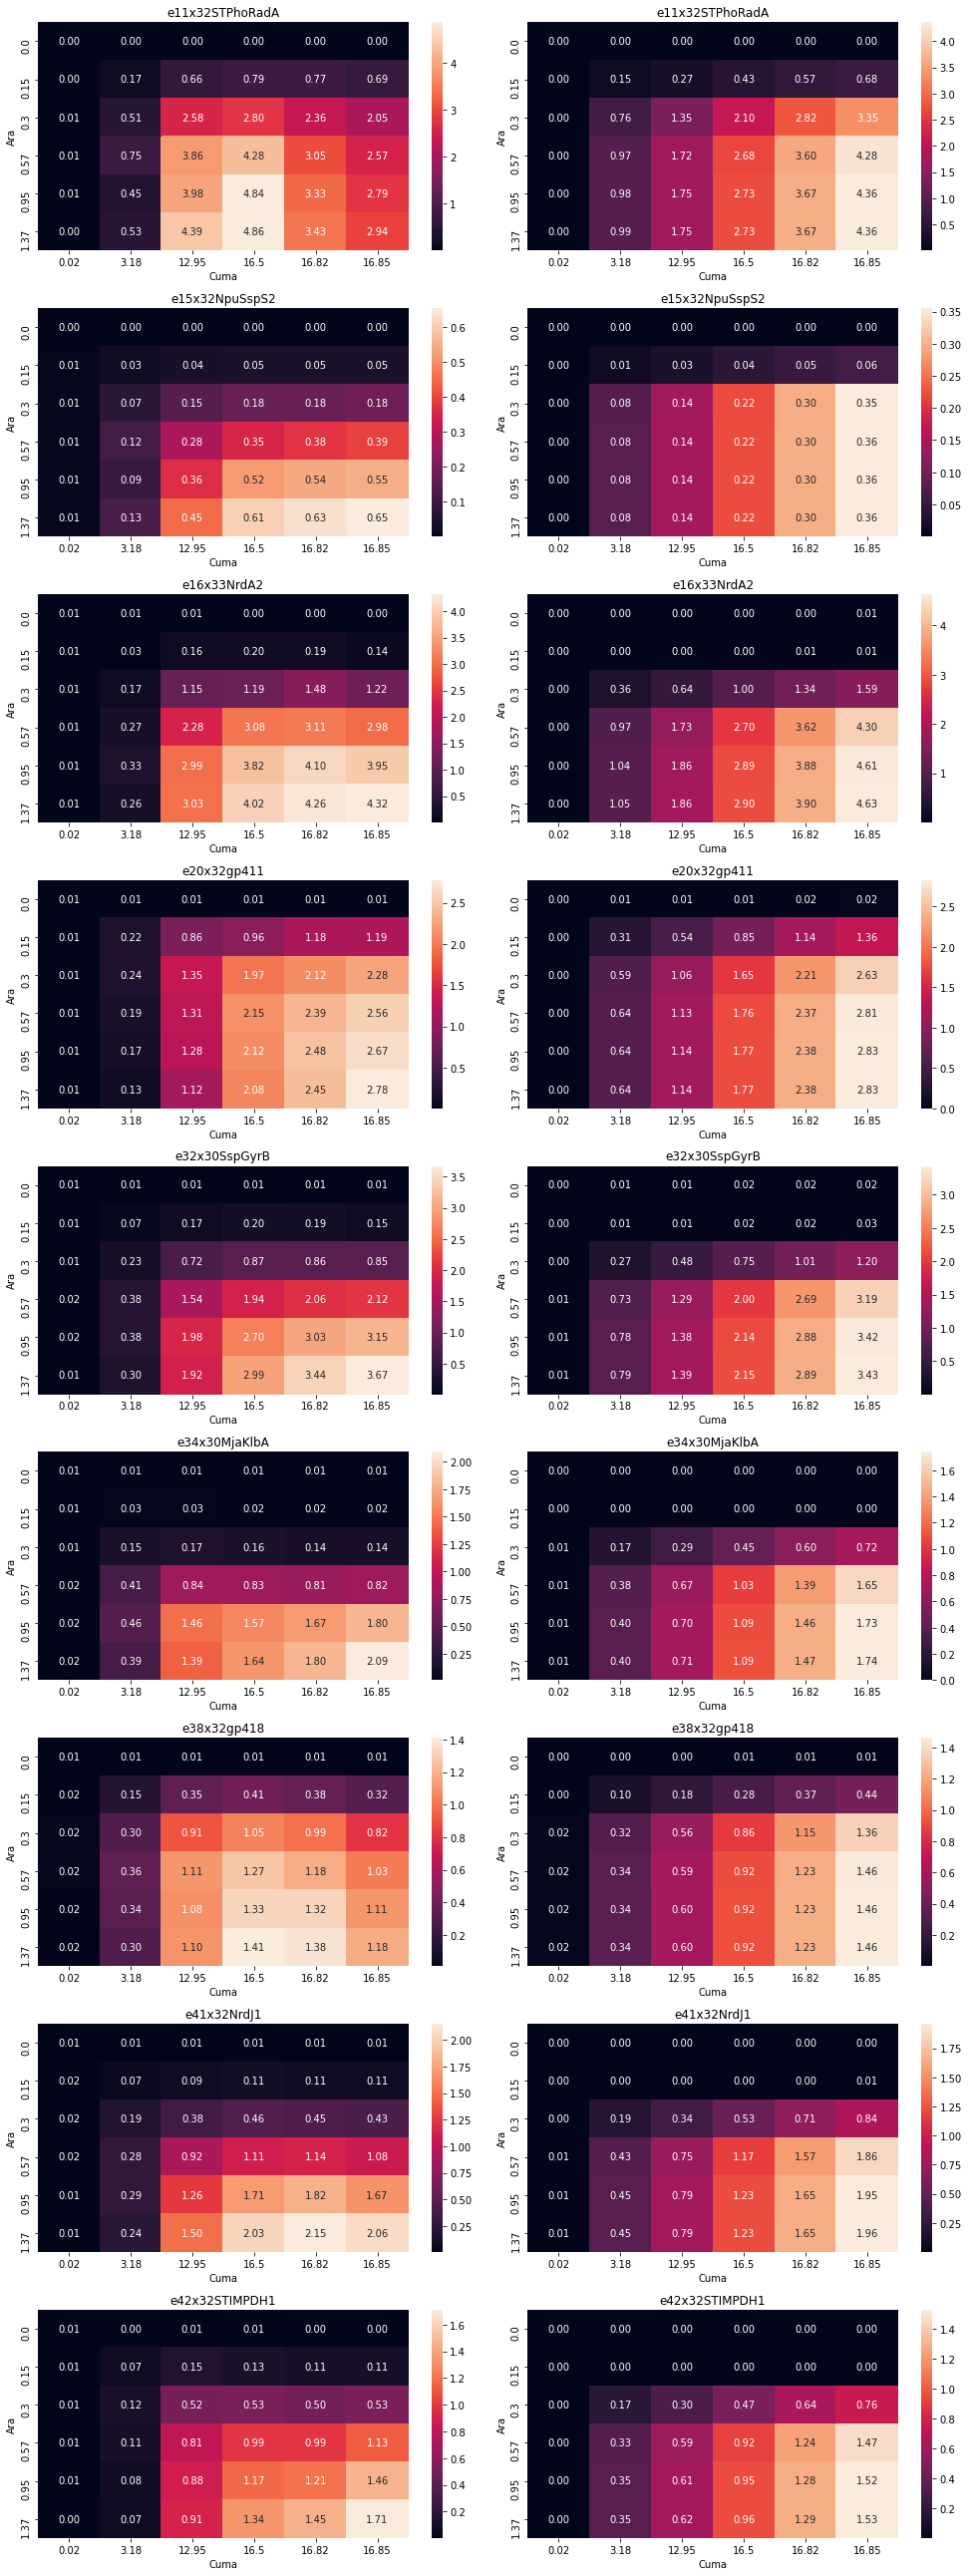

In [10]:
#complete
real_data = []
predicted_data = []

x1, x2 = np.meshgrid(cumas_rpu, aras_rpu)
x = np.vstack((x1.ravel(), x2.ravel()))

def plot_hill_equation(fluos, gates, num_row, num_col, t=600):
    
    f, axs = plt.subplots(num_row, num_col, sharex=False, sharey=False, figsize=(14, num_row*4))
    #axr = axs.ravel()
    for i, gate in enumerate(gates):
        
        fluo = fluos[filter(lambda x: x.startswith(gate), fluos.index)]
        fluo_t = fluo.transpose().reset_index().rename(columns={'index': 'gate'})
        fluo_t['cuma'] = fluo_t['gate'].str[-2]
        fluo_t['ara'] = fluo_t['gate'].str[-1]
        #fluo_pvt = fluo_t.drop('gate', axis=1).pivot('cuma', 'ara', 1440)

        y = fluo_t[t]
        h = y.max()-y.min()
        init_guess = [10, 10, 1, 1, y.min(), y.min(), y.max(), y.max()]
        gate_bounds = [[1, 1, 1, 1, 0, 0, 0, 0],
                       [1e4, 1e4, 5, 5, y.min()+0.1*y.min(), y.min()+0.1*y.min(), y.max()+0.2*y.max(), y.max()+0.2*y.max()]]
        #init_guess = randomSearch(30, len(gate_bounds[0]), x, y, gate_bounds)
        
        popt, pcov = curve_fit(hill_activation_and, x, y, p0=init_guess, bounds=gate_bounds)
        
        real_data.append(y.values)
        predicted_data.append(hill_activation_and(x, *popt))
        
        #print(gate, popt)
        
        fluo_pvt = fluo_t.drop('gate', axis=1).pivot('cuma', 'ara', t)
        fluo_pvt.index = [np.round(c, 2) for c in cumas_rpu]
        fluo_pvt.columns = [np.round(a, 2) for a in aras_rpu]
        sns.heatmap(fluo_pvt, annot=True, fmt='.2f', ax=axs[i, 0])
        
        #cf = axs[i, 0].pcolormesh(x1, x2, y.values.reshape(-1, 6), cmap='afmhot')
        #f.colorbar(cf, ax=axs[i, 0])
        axs[i, 0].set_xlabel('Cuma')
        axs[i, 0].set_ylabel('Ara')
        axs[i, 0].set_title(gate)
        #cf = axs[i, 1].pcolormesh(x1, x2, hill_activation_and(x, *popt).reshape(-1, 6), cmap='afmhot')
        #f.colorbar(cf, ax=axs[i, 1])
        
        y_hat = hill_activation_and(x, *popt)
        print(gate, popt)
        dy_hat = pd.DataFrame(pd.Series(y_hat, name='y_hat'))
        dy_hat['cuma'] = fluo_t['cuma']
        dy_hat['ara'] = fluo_t['ara']
        yhat_pvt = dy_hat.pivot('cuma', 'ara', 'y_hat')
        yhat_pvt.index = [np.round(c, 2) for c in cumas_rpu]
        yhat_pvt.columns = [np.round(a, 2) for a in aras_rpu]
        
        sns.heatmap(yhat_pvt, annot=True, fmt='.2f', ax=axs[i, 1])
        
        axs[i, 1].set_xlabel('Cuma')
        axs[i, 1].set_ylabel('Ara')
        axs[i, 1].set_title(gate)
        
    plt.tight_layout()
    plt.show()
    
plot_hill_equation(rpus, gates, 9, 2)

In [98]:
hill_params = {
    'e11x32STPhoRadA': [78.88757093255623, 13.423008910592088, 0.06750072135001235, 1.6087509603668955, 2.784245477923627, 0.31393617048589656, 5.893511281459714, 7.640639282598571],
    'e15x32NpuSspS2': [161.72360792194488, 42.22139131099884, 3.4464354202384095, 1.8800531362253823, 1.4684533238357385, 0.00615977819222413, 0.17478411118449844, 2.3896879847149957],
    'e16x33NrdA2': [0.06667890526878588, 17.489173790194126, 1.629379603920326, 3.3825169891085607, 0.0924586810761503, 0.012970301242177351, 4.883669391506718, 3.1393795603137873],
    'e20x32gp411': [156.47926227589696, 3.27145504457037, 0.1993818805303378, 1.3127871275197236, 0.6543687015953281, 0.030066033935069236, 4.994020106948165, 2.397995876040257],
    'e32x30SspGyrB': [29.115796033435117, 13.282145271696637, 0.17150169903483523, 4.4706534361172965, 0.9074242149763572, 0.05992322196815236, 4.594477595477401, 5.430775818547262],
    'e34x30MjaKlbA': [63.40240087241315, 12.585642653598384, 0.4049285326646396, 5.505373783820655, 0.14923511220024105, 0.24580246176832277, 2.808119136718859, 4.978363038236083],
    'e38x32gp418': [0.08036169728356057, 25.02984462636371, 2.9450169512324167, 1.5105557004035912, 0.5537568195542529, 0.011498806155622848, 1.8177940601768499, 2.3465260616139325],
    'e41x32NrdJ1': [91.61690207014269, 9.613173708802204, 0.19604072857578225, 4.49429075998229, 0.2633101293644491, 0.5478652267796729, 2.451050770893331, 3.742884762485401],
    'e42x32STIMPDH1': [63.191093905390304, 22.03854650130675, 0.3783875188853484, 1.8773027662146493, 0.26438112540855013, 0.23387627861636953, 3.7897947944862724, 4.004964003363907]
}

In [12]:
hill_params = {
    'e11x32STPhoRadA': [1.00000000e+00, 4.61903689e+01, 1.00000000e+00, 1.24264136e+00,
     6.58271567e-05, 6.58271547e-05, 5.82677024e+00, 5.82677027e+00],
    'e15x32NpuSspS2': [1.00000000e+00, 4.31811340e+00, 1.00000000e+00, 5.00000000e+00,
     4.32578458e-04, 2.26057479e-04, 7.83945013e-01, 7.83945013e-01],
    'e16x33NrdA2': [1.00000000e+00, 2.00042563e+01, 1.00000000e+00, 5.00000000e+00,
     1.97194788e-03, 1.97194788e-03, 5.18562536e+00, 5.18562536e+00],
    'e20x32gp411': [1.00000000e+00, 5.75626011e+00, 1.00000000e+00, 1.00000000e+00,
     6.63951643e-47, 6.35405428e-03, 2.92437918e+00, 2.24162243e+00],
    'e32x30SspGyrB': [1.00000000e+00, 1.98898429e+01, 1.00000000e+00, 5.00000000e+00,
     9.49640288e-03, 9.49640288e-03, 4.40624314e+00, 4.40624314e+00],
    'e34x30MjaKlbA': [1.00000000e+00, 1.71615282e+01, 1.00000000e+00, 5.00000000e+00,
     1.07303987e-02, 1.60662491e-14, 2.50722595e+00, 2.50722595e+00],
    'e38x32gp418': [1.,         5.67659974, 1.,        1.81776222, 0.0108867,  0.0108867,
     1.691971,   1.691971  ],
    'e41x32NrdJ1': [1.00000000e+00, 1.67517917e+01, 1.00000000e+00, 5.00000000e+00,
     7.69138489e-03, 3.03973228e-03, 2.58100461e+00, 2.58100461e+00],
    'e42x32STIMPDH1': [1.00000000e+00, 1.52172822e+01, 1.00000000e+00, 5.00000000e+00,
     2.96954423e-03, 2.96954423e-03, 2.05393704e+00, 2.05393704e+00]
}

0.44271570553478645
0.5449745131088959
0.8261629606542469
0.9088789901434098
0.8592944183260534
0.7187326271025394
0.6045461059271702
0.7790112507628855
0.8338493906950062


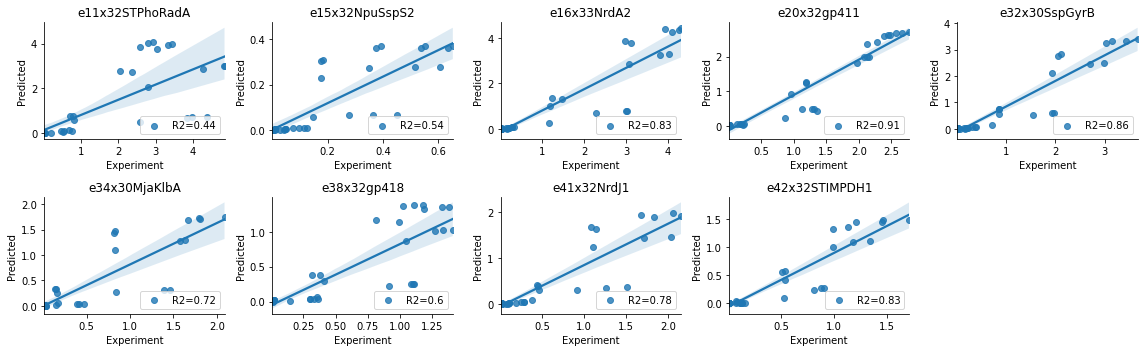

In [85]:
#complete
#1440
f, axs = plt.subplots(2, 5, sharex=False, sharey=False, figsize=(16, 5))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        sns.regplot(real_data[i].ravel(), predicted_data[i].ravel(), ax=ax, label='R2={}'.format(round(r2_score(real_data[i].ravel(), predicted_data[i].ravel()), 2)))
        #print(np.corrcoef(real_data[i].ravel(), predicted_data[i].ravel())[0][1])
        print(r2_score(real_data[i].ravel(), predicted_data[i].ravel()))
        ax.set_title(gates[i])
        ax.set_xlabel('Experiment')
        ax.set_ylabel('Predicted')
        ax.legend(loc=4)
        sns.despine()
    else:
        ax.set_visible(False)
    plt.tight_layout()

### Multiple Datapoints Individually

In [22]:
#without sampling
real_datas = []
predicted_datas = []
popt_datas = []

for gate in tqdm(gates):
    
    fluo = fluos[filter(lambda x: x.startswith(gate), fluos.columns)]
    fluo_t = fluo.transpose().reset_index().rename(columns={'index': 'gate'})
    real_data = []
    predicted_data = []
    popt_data = []

    for i in range(0, 1460, 20):
        
        y = fluo_t[i]
        y[y < 0] = 0.01 #replace negative values
        
        init_guess = [10, 10, 1, 1, y.min(), y.min(), y.max(), y.max()]
        gate_bounds = [[1, 1, 1, 1, 0, 0, 0, 0],
                       [1e4, 1e4, 6, 6, y.min()+0.1*y.min(), y.min()+0.1*y.min(), y.max()+0.2*y.max(), y.max()+0.2*y.max()]]
        #init_guess = randomSearch(30, len(gate_bounds[0]), x, y, gate_bounds)
        
        popt, pcov = curve_fit(hill_activation_and, x, y, p0=init_guess, bounds=gate_bounds)
        popt_data.append(popt)
        real_data.append(y.values)
        predicted_data.append(hill_activation_and(x, *popt))
    
    popt_datas.append(popt_data)
    real_datas.append(np.array(real_data).ravel())
    predicted_datas.append(np.array(predicted_data).ravel())

100%|██████████| 9/9 [01:17<00:00,  8.60s/it]


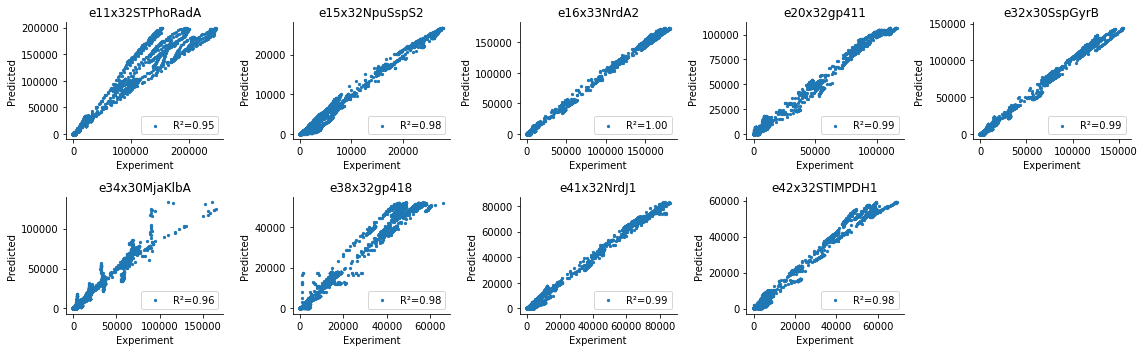

In [14]:
#complete
f, axs = plt.subplots(2, 5, sharex=False, sharey=False, figsize=(16, 5))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        r2 = 'R\u00b2={:.2f}'.format(r2_score(real_datas[i], predicted_datas[i]))
        ax.scatter(real_datas[i], predicted_datas[i], s=5, label=r2)
        ax.set_title(gates[i])
        ax.set_xlabel('Experiment')
        ax.set_ylabel('Predicted')
        ax.legend(loc=4)
        sns.despine()
    else:
        ax.set_visible(False)
    plt.tight_layout()

In [88]:
#with sampling, somehow it does not work
real_datas = []
predicted_datas = []
popt_datas = []

for gate in gates:
    
    print(gate)
    fluo = rpus[filter(lambda x: x.startswith(gate), rpus.index)]
    fluo_t = fluo.transpose().reset_index().rename(columns={'index': 'gate'})
    real_data = []
    predicted_data = []
    popt_data = []

    y = fluo_t[600]
    y[y < 0] = 0.01 #replace negative values
    h = y.max() - y.min()

    #init_guess = [10, 10, 1, 1, y.min(), y.min(), y.max(), y.max()]
    gate_bounds = [[1, 1, 1, 1, 0, 0, 0, 0],
                   [1e4, 1e4, 6, 6, y.min()+h, y.min()+h, y.max()+h, y.max()+h]]
    init_guess = randomSearch(20, x, y, gate_bounds, hill_activation_and)

    popt, pcov = curve_fit(hill_activation_and, x, y, p0=init_guess, bounds=gate_bounds, maxfev=5000)
    popt_data.append(popt)
    real_data.append(y.values)
    predicted_data.append(hill_activation_and(x, *popt))
    
    popt_datas.append(popt_data)
    real_datas.append(np.array(real_data).ravel())
    predicted_datas.append(np.array(predicted_data).ravel())

e11x32STPhoRadA
e15x32NpuSspS2
e16x33NrdA2
e20x32gp411
e32x30SspGyrB
e34x30MjaKlbA
e38x32gp418
e41x32NrdJ1
e42x32STIMPDH1


In [89]:
param_names = ['K1', 'K2', 'n1', 'n2', 'ymin1', 'ymin2', 'ymax1', 'ymax2']
df_params = pd.DataFrame()
for i in range(len(gates)):
    temp = pd.DataFrame(popt_datas[i], columns=param_names)
    temp['gate'] = gates[i]
    df_params = df_params.append(temp)

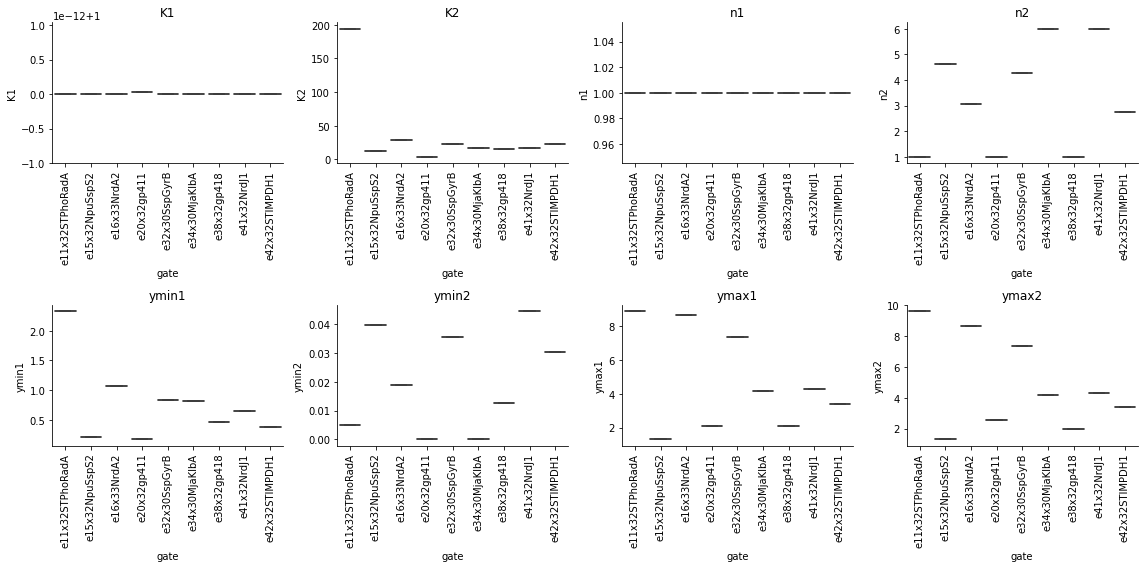

In [90]:
#complete
f, axs = plt.subplots(2, 4, sharex=False, sharey=False, figsize=(16, 8))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(param_names):
        single_param = df_params[['gate', param_names[i]]]
        sns.boxplot(x='gate', y=param_names[i], data=single_param, showfliers=False, ax=ax)
        ax.set_title(param_names[i])
        ax.set_xticklabels(gates, rotation=90)
        sns.despine()
    else:
        ax.set_visible(False)
    plt.tight_layout()

In [91]:
popt_datas

[[array([1.00000000e+00, 1.93951091e+02, 1.00000000e+00, 1.00000000e+00,
         2.32702892e+00, 4.95947852e-03, 8.86789165e+00, 9.59759187e+00])],
 [array([ 1.        , 13.03775178,  1.        ,  4.62441963,  0.20840674,
          0.03968775,  1.30618177,  1.30618177])],
 [array([1.00000000e+00, 2.81244677e+01, 1.00000000e+00, 3.05985892e+00,
         1.07437421e+00, 1.90174539e-02, 8.64091626e+00, 8.64091626e+00])],
 [array([1.00000000e+00, 3.87291915e+00, 1.00000000e+00, 1.00000000e+00,
         1.69912182e-01, 8.11012472e-13, 2.07513902e+00, 2.54317815e+00])],
 [array([ 1.        , 22.2695803 ,  1.        ,  4.28915608,  0.83319221,
          0.03537311,  7.33510547,  7.33510547])],
 [array([1.00000000e+00, 1.73447847e+01, 1.00000000e+00, 6.00000000e+00,
         8.17143810e-01, 7.65539747e-20, 4.16895501e+00, 4.16895501e+00])],
 [array([1.00000000e+00, 1.54946803e+01, 1.00000000e+00, 1.00000000e+00,
         4.70333047e-01, 1.27986808e-02, 2.09888233e+00, 1.98558318e+00])],
 [arr

#### Fitting at the Same Time

In [ ]:
def test_multiple():
    
    def hill_activation_simplified(x, K, n, ymin):
    
        return ymin + (1 - ymin) * (x**n / (K**n + x**n))
    
    def hill_activation_simple(x, K1, K2, n1, n2, ymin1, ymin2):
    
        x1, x2 = x
        return hill_activation_simplified(x1, K1, n1, ymin1) * hill_activation_simplified(x2, K2, n2, ymin2)
    
    def hill_activation_combined(x, K1, K2, n1, n2, ymin1, ymin2):
        
        result = []
        for i in range(start, end, gap):
            temp = hill_activation_simple(x, K1, K2, n1, n2, ymin1, ymin2)
            result = np.append(result, temp)   
        return result
    
    x1, x2 = np.meshgrid(cumas, aras)
    x = np.vstack((x1.ravel(), x2.ravel()))
    f_params = []
    
    #gate = 'e20x32gp411'
    for gate in tqdm(gates):
        
        fluo = fluos[filter(lambda x: x.startswith(gate), fluos.columns)]
        fluo_t = fluo.transpose().reset_index().rename(columns={'index': 'gate'})

        y = pd.Series()
        start, end, gap = 0, 1460, 20
        dp = int((end-start)/gap)
        for t in range(start, end, gap):
            y_ = fluo_t[t]
            y_[y_ < 0] = 0.01 #replace negative values
            y_ = y_ / y_.max()
            y = y.append(y_)
        '''
        minmax_init = dp * [y.min(), y.min(), y.max(), y.max()]
        minmax_low = dp * [0, 0, 0, 0]
        minmax_up = dp * [y.min()+0.1*y.min(), y.min()+0.1*y.min(), y.max()+0.2*y.max(), y.max()+0.2*y.max()]
        init_guess = np.append([10, 10, 1, 1], minmax_init)
        gate_bounds = [np.append([1, 1, 1, 1], minmax_low), np.append([1e5, 1e5, 7, 7], minmax_up)]
        '''
        
        
        init_guess = [10, 10, 1, 1, y.min(), y.min()]
        gate_bounds = [[1, 1, 1, 1, y.min()-0.01, y.min()-0.01],
                   [1e4, 1e4, 5, 5, y.min()+0.1*y.min(), y.min()+0.1*y.min()]]
        '''

        init_guess = [10, 10, 1, 1, y.min(), y.min(), y.max(), y.max()]
        gate_bounds = [[1, 1, 1, 1, 0, 0, 0, 0], [1e4, 1e4, 6, 6, y.min()+0.1*y.min(), y.min()+0.1*y.min(), y.max()+0.2*y.max(), y.max()+0.2*y.max()]]
        '''
        f_param, f_cov = curve_fit(hill_activation_combined, x, y, p0=init_guess, bounds=gate_bounds)
        f_params.append(f_param)
    
    return f_params
    
f_params = test_multiple()

In [ ]:
f_params

In [ ]:
def hill_activation_simple(x, K1, K2, n1, n2, ymin1, ymin2):

    x1, x2 = x
    return hill_activation_simplified(x1, K1, n1, ymin1) * hill_activation_simplified(x2, K2, n2, ymin2)


def hill_activation_simplified(x, K, n, ymin):

    return ymin + (1 - ymin) * (x**n / (K**n + x**n))

In [ ]:
#gate = gates[6]
real_datas = []
predicted_datas = []
for gate in gates:
    fluo = fluos[filter(lambda x: x.startswith(gate), fluos.columns)]
    fluo_t = fluo.transpose().reset_index().rename(columns={'index': 'gate'})
    real_data = []
    predicted_data = []
    for t in range(0, 1460, 20):
        train = fluo_t[t]
        train_max = train.max()
        train = train / train_max
        test = hill_activation_simple(x, *f_params[6])
        real_data.append(train)
        predicted_data.append(test)
        
        print(gate, t, r2_score(train, test))
    real_datas.append(np.array(real_data).ravel())
    predicted_datas.append(np.array(predicted_data).ravel())
    #print(gate, r2_score(np.array(real_data).ravel(), np.array(predicted_data).ravel()))

In [ ]:
gates[5]

In [ ]:
sns.regplot(train, test)

In [ ]:
#simplified
f, axs = plt.subplots(2, 5, sharex=False, sharey=False, figsize=(16, 5))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        r2 = 'R\u00b2={:.2f}'.format(r2_score(real_datas[i], predicted_datas[i]))
        ax.scatter(real_datas[i], predicted_datas[i], s=5, label=r2)
        ax.set_title(gates[i])
        ax.set_xlabel('Experiment')
        ax.set_ylabel('Predicted')
        ax.legend(loc=4)
        sns.despine()
    else:
        ax.set_visible(False)
    plt.tight_layout()

### Dynamic Models

In [28]:
#at 24h
hill_params = {
    'e11x32STPhoRadA': [8.19215086e+00, 2.77324618e+00, 6.00000000e+00, 1.24643956e+00, 5.95605924e+00, 3.46957143e-09, 2.99296531e+02, 5.36128135e+02],
    'e15x32NpuSspS2': [9.8458614, 8.7957319, 2.89598247, 1., 36.84876916, 30.33289918, 156.72063863, 156.06142356],
    'e16x33NrdA2': [10.13165313, 6.30849837, 5.02963422, 1.26435637, 15.99371476, 6.8959355, 380.68087314, 387.7069378],
    'e20x32gp411': [12.53828935, 1., 2.78451886, 1.49241488, 8.39069666, 27.77880598, 314.77726787, 311.65818168],
    'e32x30SspGyrB': [10.77387795, 8.56616674, 3.12574014, 1.07032582, 15.2982435, 11.91592347, 342.96437349, 343.5314864],
    'e34x30MjaKlbA': [8.42632247, 13.40974257, 3.28555513, 1.81757507, 3.4673668, 20.82148359, 307.13693296, 290.48137472],
    'e38x32gp418': [7.61231223, 1.51099399, 5.04169259, 1.4068252, 26.05989294, 20.59322098, 218.62810381, 218.64413488],
    'e41x32NrdJ1': [9.59574651, 12.05238497, 3.84271899, 1., 21.72980962, 19.19063999, 277.09322359, 275.39980816],
    'e42x32STIMPDH1': [10.41225458, 5.87647366, 4.30770405, 1.01184319, 22.82771137, 18.70845616, 228.18083668, 227.98611955]
}

In [ ]:
#objective function
def computeSSE(f_p0, f_t, f_data, f_bounds, ind1, ind2, params):
    
    def model_fit(t, r, y0, synGFP, degGFP):
        
        fit = gate_wrapper(t, r, y0, synGFP, degGFP, ind1, ind2, params)
        return fit[1]
    
    popt, pcov = curve_fit(model_fit, f_t, f_data, p0=f_p0, bounds=f_bounds)
    print(popt)
    f_sim = model_fit(f_t, *popt)
    
    error = [(val-sal)**2 for val, sal in zip(f_sim, f_data)]
    
    return sum(error)

#generate random numbers from a uniform distribution for the initial guesses
def randomSearch(iterations, num_params, f_t, f_data, bounds, ind1, ind2, params):
    
    initialGuesses = []
    for k in range(iterations):
        guess = [np.random.uniform(low=low, high=high) for low, high in zip(bounds[0], bounds[1])]
        error = computeSSE(guess, f_t, f_data, bounds, ind1, ind2, params)
        initialGuesses.append((error, guess))
    
    sortedGuesses = sorted(initialGuesses)
    bestGuess = sortedGuesses[0][1]
    
    return bestGuess

In [29]:
def growth_rate(OD, alpha, beta):
    return (alpha * (1 - (OD/beta)))

def gate_wrapper(t, r, y0, synGFP, degGFP, x1, x2, params):
    
    K1, K2, n1, n2, ymin1, ymin2, ymax1, ymax2 = params
    ymax = hill_activation_and((x1, x2), K1, K2, n1, n2, ymin1, ymin2, ymax1, ymax2)
    
    def gate_model(y, t):
        y1, GFP = y
        dy1 = r * (1 - (y1/ymax)) * y1
        dGFP = synGFP * y1 - degGFP * GFP
        return [dy1, dGFP]
    
    solution = odeint(gate_model, [y0, 0], t)
    return solution.transpose()

def fit_simple(fluo, ind1, ind2, params):
    
    f_t = fluo.index
    f_data = fluo.copy()
    
    parameters = ['r', 'y0', 'synGFP', 'degGFP']
    init_guess = [0.1, 0.1, 0, 0.02]
    gate_bounds_together = [[0, 1e-3, 0, 0], [1e4, 1e4, 1e4, 1e2]]
    #init_guess = randomSearch(20, len(gate_bounds_together[0]), f_t, f_data, gate_bounds_together, ind1, ind2, params)
    
    def model_fit(t, r, y0, synGFP, degGFP):
        
        fit = gate_wrapper(t, r, y0, synGFP, degGFP, ind1, ind2, params)
        return fit[1]
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guess, bounds=gate_bounds_together)#, method='dogbox')
    f_sim = pd.Series(model_fit(f_t, *f_params), index=f_t)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_data

def fit_simple_fixed_deg(fluo, ind1, ind2, params):
    
    f_t = fluo.index
    f_data = fluo.copy()
    
    parameters = ['r', 'y0', 'synGFP']
    init_guess = [1, 0.1, 0]
    gate_bounds_together = [[0, 1e-1, 0], [1e2, 1e4, 1e5]]
    
    def model_fit(t, r, y0, synGFP):
        
        fit = gate_wrapper(t, r, y0, synGFP, 0.01, ind1, ind2, params)
        return fit[1]
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guess, bounds=gate_bounds_together)#, method='dogbox')
    f_sim = pd.Series(model_fit(f_t, *f_params), index=f_t)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_data


def gate_wrapper2(t, r, y0, x1, x2, params):
    
    K1, K2, n1, n2, ymin1, ymin2, ymax1, ymax2 = params
    ymax = hill_activation_and((x1, x2), K1, K2, n1, n2, ymin1, ymin2, ymax1, ymax2)
    
    def gate_model(y, t):
        y1 = y[0]
        dy1 = r * (1 - (y1/ymax)) * y1
        return [dy1]
    
    solution = odeint(gate_model, [y0], t)
    return solution.transpose()

def gate_wrapper3(t, r, y0, synGFP, x1, x2, hill_params, od_params):
    
    K1, K2, n1, n2, ymin1, ymin2, ymax1, ymax2 = hill_params
    ymax = hill_activation_and((x1, x2), K1, K2, n1, n2, ymin1, ymin2, ymax1, ymax2)
    print(ymax)
    
    def gate_model(y, t):
        y1, GFP, OD = y
        dil = growth_rate(OD, od_params[0], od_params[1])
        dOD = dil * OD
        dy1 = r * (1 - (y1/ymax)) * y1
        dGFP = synGFP * y1 - dil * GFP
        return [dy1, dGFP, dOD]
    
    solution = odeint(gate_model, [y0, 0, 0], t)
    return solution.transpose()

def fit_simple2(fluo, ind1, ind2, params):
    
    f_t = fluo.index
    f_data = fluo.copy()
    
    parameters = ['r', 'y0']
    init_guess = [0.1, 0.1]
    gate_bounds_together = [[0, 1e-1], [1e2, 1e4]]
    
    def model_fit(t, r, y0):
        
        fit = gate_wrapper2(t, r, y0, ind1, ind2, params)
        return fit[0]
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guess, bounds=gate_bounds_together)#, method='dogbox')
    f_sim = pd.Series(model_fit(f_t, *f_params), index=f_t)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_data

def fit_simple_new(fluo, ind1, ind2, hill_params, od_params):
    
    f_t = fluo.index
    f_data = fluo.copy()
    
    parameters = ['r', 'y0', 'synGFP']
    init_guess = [1, 0.1, 0]
    gate_bounds_together = [[0, 1e-1, 0], [1e2, 1e4, 1e5]]
    
    def model_fit(t, r, y0, synGFP):
        
        fit = gate_wrapper3(t, r, y0, synGFP, ind1, ind2, hill_params, od_params)
        return fit[1]
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guess, bounds=gate_bounds_together)#, method='dogbox')
    f_sim = pd.Series(model_fit(f_t, *f_params), index=f_t)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_data

def fit_simple_fixed(fluo, ind1, ind2, params):
    
    f_t = fluo.index
    f_data = fluo.copy()
    
    parameters = ['r']
    init_guess = [0.5]
    gate_bounds_together = [[0], [1]]
    
    def model_fit(t, r):
        
        fit = gate_wrapper(t, r, 0.1, 0.1, 0.3, ind1, ind2, params)
        return fit[1]
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guess, bounds=gate_bounds_together)#, method='dogbox')
    #f_params, f_cov = curve_fit(model_fit, f_t, f_data)#, method='dogbox')
    
    f_sim = pd.Series(model_fit(f_t, *f_params), index=f_t)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_data

In [30]:
gate = 'e42x32STIMPDH1'
print(gate)
a = 5
b = 5
cuma = cumas[a]
ara = aras[b]
fluo = fluos['{}_{}{}'.format(gate, a, b)]
#f_df, f_sim, f_data = fit_simple_new(fluo, cuma, ara, hill_params[gate], od_params['{}_{}{}'.format(gate, a, b)])
#f_df, f_sim, f_data = fit_simple_fixed_deg(fluo, cuma, ara, hill_params[gate])
f_df, f_sim, f_data = fit_simple(fluo, cuma, ara, hill_params[gate])

e42x32STIMPDH1


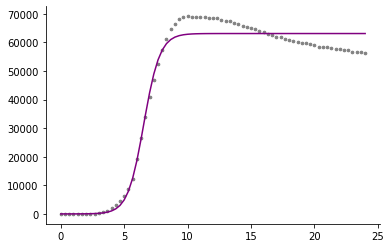

In [31]:
plt.scatter(fluo.index/60, fluo, s=7, color='gray')
plt.plot(fluo.index/60, f_sim, color='purple')
sns.despine()

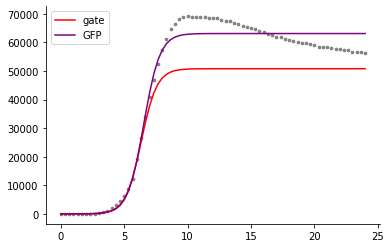

In [32]:
sim = gate_wrapper(fluo.index, *f_df['Value'].tolist(), cuma, ara, hill_params[gate])
plt.scatter(fluo.index/60, fluo, s=7, color='gray')
plt.plot(fluo.index/60, sim[0], color='red', label='gate')
plt.plot(fluo.index/60, sim[1], color='purple', label='GFP')
plt.legend()
sns.despine()

In [35]:
f_df

,Parameters,Value,Err,gate
0,r,0.026992,0.010936,e42x32STIMPDH1
1,y0,1.753310,2.352358,e42x32STIMPDH1
2,synGFP,0.099728,0.957011,e42x32STIMPDH1
3,degGFP,0.080273,0.770354,e42x32STIMPDH1


In [33]:
gate_params = pd.DataFrame()

10it [00:30,  3.03s/it]


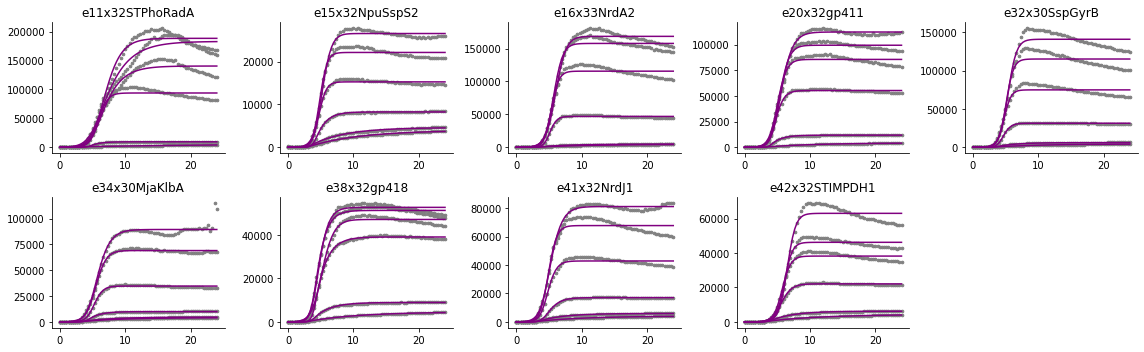

In [34]:
f, axs = plt.subplots(2, 5, sharex=False, sharey=False, figsize=(16, 5))
axr = axs.ravel()
for i, ax in tqdm(enumerate(axr)):
    if i < len(gates):
        gate = gates[i]
        #j = 5
        for k in range(6):
            fluo = fluos['{}_{}{}'.format(gate, k, k)]
            f_df, f_sim, f_data = fit_simple(fluo, cumas[k], aras[k], hill_params[gate])
            f_df['gate'] = '{}'.format(gate)
            #gate_params = gate_params.append(f_df)
            ax.scatter(fluo.index/60, fluo, s=7, color='gray')
            ax.plot(fluo.index/60, f_sim, color='purple')
        ax.set_title(gate)
        sns.despine()
    else:
        ax.set_visible(False)
plt.tight_layout()

In [ ]:
r_gate_params = gate_params[gate_params['Parameters']=='r']
y0_gate_params = gate_params[gate_params['Parameters']=='y0']
synGFP_gate_params = gate_params[gate_params['Parameters']=='synGFP']
degGFP_gate_params = gate_params[gate_params['Parameters']=='degGFP']

In [ ]:
f, axs = plt.subplots(1, 4, sharex=False, sharey=False, figsize=(18, 5))
ax = axs.ravel()
sns.boxplot(x='gate', y='Value', data=r_gate_params, showfliers=False, ax=ax[0])
ax[0].set_xticklabels(gates, rotation=90)
ax[0].set_title('r')
sns.despine()
sns.boxplot(x='gate', y='Value', data=y0_gate_params, showfliers=False, ax=ax[1])
ax[1].set_xticklabels(gates, rotation=90)
ax[1].set_title('y0')
sns.despine()
sns.boxplot(x='gate', y='Value', data=synGFP_gate_params, showfliers=False, ax=ax[2])
ax[2].set_xticklabels(gates, rotation=90)
ax[2].set_title('synGFP')
sns.despine()
sns.boxplot(x='gate', y='Value', data=degGFP_gate_params, showfliers=False, ax=ax[3])
ax[3].set_xticklabels(gates, rotation=90)
ax[3].set_title('degGFP')
sns.despine()
plt.tight_layout()

In [ ]:
gate_params2

In [ ]:
f, axs = plt.subplots(2, 5, sharex=False, sharey=False, figsize=(16, 5))
axr = axs.ravel()
for i, ax in tqdm(enumerate(axr)):
    if i < len(gates):
        gate = gates[i]
        fluo = fluos['{}_{}{}'.format(gate, 5, 5)]
        f_df, f_sim, f_data = fit_simple(fluo, cumas[5], aras[5], hill_params[gate])
        f_df['gate'] = '{}'.format(gate)
        
        sim = gate_wrapper(fluo.index, *f_df['Value'].tolist(), cumas[5], aras[5], hill_params[gate])
        ax.scatter(fluo.index/60, fluo, s=7, color='gray')
        ax.plot(fluo.index/60, sim[0], color='red', label='gate')
        ax.plot(fluo.index/60, sim[1], color='purple', label='GFP')
        ax.legend()
        
        ax.set_title(gate)
        sns.despine()
    else:
        ax.set_visible(False)
plt.tight_layout()

#### Fixing y0 and synGFP

In [ ]:
y0_gate_params['Value'].median(), synGFP_gate_params['Value'].median()

In [ ]:
gate_params = pd.DataFrame()
for gate in tqdm(gates):
    #gate = 'e42x32STIMPDH1'
    for i in range(6):
        for j in range(6):
            fluo = fluos['{}_{}{}'.format(gate, i, j)]
            f_df, f_sim, f_data = fit_simple(fluo, cuma_list[i], ara_list[j], hill_params[gate])
            #gate_params['{}_{}{}'.format(gate, i, j)] = f_df['Value'].tolist()
            f_df['gate'] = '{}'.format(gate)
            gate_params = gate_params.append(f_df)

In [ ]:
sns.boxplot(x='gate', y='Value', data=gate_params, showfliers=False)
plt.xticks(rotation=90)
sns.despine()
plt.tight_layout()

In [ ]:
gate_params.groupby(['gate', 'Parameters']).median()['Value']

In [ ]:
sim = gate_wrapper(fluo.index, 2.32417559e-02, 1.24218505e+02, 1.84759326, 0.2, cuma_list[3], ara_list[3], hill_params[gate])
plt.plot(fluo.index, sim[0], label='gate')
plt.plot(fluo.index, sim[1], label='reporter')
plt.legend()
sns.despine()

In [ ]:
sim = gate_wrapper(fluo.index, 2.32417559e-02, 1.24218505e+02, 1.84759326e-02, 0.2, cuma_list[5], ara_list[5], hill_params[gate])
plt.plot(fluo.index, sim[0], label='gate')
plt.plot(fluo.index, sim[1], label='reporter')
plt.legend()
sns.despine()

In [ ]:
for i in range(6):
    plt.plot(fluo.index, gate_wrapper(fluo.index, 2.32417559e-02, 1.24218505e+02, 1.84759326e-02, 0.02, cuma_list[i], ara_list[i], hill_params[gate])[1], label=i)
plt.legend()
sns.despine()

#### Fitting Altogether

In [ ]:
f_dfs = []
f_sims = []
f_ts = []
f_datas = []
for sel, gate in tqdm(enumerate(gates)):
    
    gate = gates[sel]
    #print(sel, gate)
    fluo_sel = pd.concat([fluos[i].iloc[:,sel] for i in range(4)], axis=1)
    od_sel = pd.concat([ods[i].iloc[:,sel] for i in range(4)], axis=1)
    
    od_params_sel = od_inference(od_sel)
    #od_params.append(od_params_sel)
    
    f_df, f_sim, f_t, f_data = fit_single_state(fluo_sel.iloc[:,n], od_params_sel[n], int(n/2), n%2)
    f_dfs.append(f_df)
    f_sims.append(f_sim)
    f_ts.append(f_t)
    f_datas.append(f_data)
    
#len(od_params)

Fitting with sampling initial guesses.

In [ ]:
f, axs = plt.subplots(2, 6, sharex=True, sharey=True, figsize=(14, 4))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.scatter(f_ts[i]/60, f_datas[i], c='slategrey', s=7)
        ax.plot(f_ts[i]/60, f_sims[i], c='deeppink')
        ax.set_title(gates[i])
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

Fitting without sampling initial guesses.

In [ ]:
f, axs = plt.subplots(2, 6, sharex=True, sharey=False, figsize=(14, 4))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.scatter(f_ts[i]/60, f_datas[i], c='slategrey', s=7)
        ax.plot(f_ts[i]/60, f_sims[i], c='deeppink')
        ax.set_title(gates[i])
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

#### Parameters

In [ ]:
def plot_parameters(f_df, show_err=True):
    
    parameters = f_df[0]['Parameters'].values
    n_paras = len(parameters)
    values = np.stack([df['Value'].values for df in f_df])
    errors = np.stack([df['Err'].values for df in f_df])
    
    f, axs = plt.subplots(int(n_paras/3), 3, sharex=True, figsize=(16, (n_paras+1)/2))
    for i, ax in enumerate(axs.ravel()):
        if i < n_paras:
            if show_err:
                ax.errorbar(gates, values[:,i], errors[:,i], fmt='o', label='experiment')
            else:
                ax.scatter(gates, values[:,i], label='experiment')
            ax.set_ylabel(parameters[i])
        else:
            ax.set_visible(False)
        #ax.set_xticks(rotation=90) 
        ax.set_xticklabels(gates, rotation=90)
    sns.despine()
    plt.tight_layout()
    
plot_parameters(f_dfs)

#### Manual Fitting

In [ ]:
def simulate_single_state(fluo, od_params, title, ind1, ind2):
    
    parameters = ['bn', 'bc', 'bg', 'syn_ECFn', 'syn_ECFc', 'syn_ECF', 'deg', 'syn_GFP', 'deg_GFP', 'a', 'K', 'n']
    f_t = fluo.index
    f_data = fluo.copy()
    extra = (od_params[0], od_params[1])
    y0 = pd.Series(np.append(np.zeros(4), od_params[2]))
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0)
        return pd.Series(fit[3])
    
    f_params = [par[i] for i in parameters]
    f_sim = model_fit(f_t, *f_params)
    return f_t, f_data, f_sim

In [ ]:
par = {
    'bn': 1 * 10**-1,
    'bc': 1 * 10**-1,
    'bg': 1 * 10**-2,
    'syn_ECFn': 4 * 10**0,
    'syn_ECFc': 4 * 10**0,
    'syn_ECF': 50 * 10**-10,
    'deg': 7 * 10**-3,
    'syn_GFP': 1 * 10**4,
    'deg_GFP': 1 * 10**-2,
    'K': 1 * 10**-1,
    'n': 2 * 10**0
}

In [ ]:
f, axs = plt.subplots(3, 4, figsize=(16, 2*3), sharey=False)
for m in range(1, 2):
    for i in range(0, 5):

        par = {
            'bn': 1 * 10**-10,
            'bc': 1 * 10**-10,
            'bg': 8 * 10**1,
            'syn_ECFn': 4 * 10**1,
            'syn_ECFc': 4 * 10**1,
            'syn_ECF': 50 * 10**-10,
            'deg': 7 * 10**-3,
            'syn_GFP': 3 * 10**3,
            'deg_GFP': 2 * 10**-2,
            'K': 5 * 10**-1,
            'n': 2 * 10**0
        }
        #print(par['n'])
        for n in range(4):
            f_t_sin, f_data_sin, f_sim_sin = simulate_single_state(fluo_sel.iloc[:,n], od_params_sel[n], gates[sel], int(n/2), n%2)
            axs[m-1, n].plot(f_t_sin/60, f_sim_sin, label=i)
            axs[m-1, n].legend()
plt.xticks(rotation=90)
sns.despine()
plt.tight_layout()

In [ ]:
f_t = np.concatenate([fluo_sel.index] * 4)
f_data = pd.concat([fluo_sel.iloc[:,i] for i in range(4)])
f, axs = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(12, 3))
axr = axs.ravel()
idx = len(fluo_sel.iloc[:,0])
for i, ax in enumerate(axr):
    ax.scatter(f_t[idx*i:idx*(i+1)]/60, f_data[idx*i:idx*(i+1)], c='slategrey', s=7)
    ax.set_title(gate + '-' + format(i, '02b'))
    ax.set_xlabel('Time (h)')
plt.tight_layout()
sns.despine()

#### More elegant fitting

In [ ]:
#objective function
def computeSSE(init_params, f_t, f_data, bounds, od_params, ind1, ind2):
    
    extra = (od_params[0], od_params[1])
    y0 = pd.Series(np.append(np.zeros(4), od_params[2]))
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0)
        return pd.Series(fit[3])
    
    f_params, _ = curve_fit(model_fit, f_t, f_data, p0=init_params, bounds=bounds)
    solution = model_fit(f_t, *f_params)
    error = [(val-sal)**2 for val, sal in zip(solution, f_data)]
    
    return sum(error)

#generate random numbers from a uniform distribution for initial guesses
def randomSearch(iterations, num_params, f_t, f_data, bounds, od_params, ind1, ind2):
    
    initialGuesses = []
    for k in tqdm(range(iterations)):
        guess = [np.random.uniform(low=low, high=high) for low, high in zip(bounds[0], bounds[1])]
        #guess.append(np.random.uniform(low=1,high=4))
        error = computeSSE(guess, f_t, f_data, bounds, od_params, ind1, ind2)
        initialGuesses.append((error, guess))
    
    sortedGuesses = sorted(initialGuesses)
    bestGuess = sortedGuesses[0][1]
    
    return bestGuess

In [ ]:
def fit_single_state(fluo, od_params, ind1, ind2):
    
    parameters = ['bn', 'bc', 'bg', 'syn_ECFn', 'syn_ECFc', 'syn_ECF', 'deg', 'syn_GFP', 'deg_GFP', 'K', 'n']
    f_t = fluo.index
    f_data = fluo.copy()
    extra = (od_params[0], od_params[1])
    y0 = pd.Series(np.append(np.zeros(4), od_params[2]))
    
    lower_bounds = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
    upper_bounds = [1e1, 1e1, 1e1, 1e2, 1e2, 1e-4, 1e-1, 1e5, 1e0, 1e2, 4]
    gate_bounds = [lower_bounds, upper_bounds]
    
    init_guesses = randomSearch(10, len(parameters), f_t, f_data, gate_bounds, od_params, ind1, ind2)
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0)
        return pd.Series(fit[3])
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guesses, bounds=gate_bounds)
    f_sim = model_fit(f_t, *f_params)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_t, f_data

In [ ]:
f_df_sin_all = []
for n in range(4):
    f_df_sin, f_sim_sin, f_t_sin, f_data_sin = fit_single_state(fluo_sel.iloc[:,n], od_params_sel[n], int(n/2), n%2)
    f_df_sin_all.append(f_df_sin)

In [ ]:
guesses = []
lowers = []
uppers = []
for param in tqdm(f_df_sin['Parameters']):
    vals = [i.loc[i['Parameters']==param, 'Value'].values for i in f_df_sin_all]
    lows = [(i.loc[i['Parameters']==param, 'Value'].values - i.loc[i['Parameters']==param, 'Err'].values) for i in f_df_sin_all]
    highs = [(i.loc[i['Parameters']==param, 'Value'].values + i.loc[i['Parameters']==param, 'Err'].values) for i in f_df_sin_all]
    #print('v', vals) 
    #print('l', lows)
    #print('h', highs)
    guesses.append(np.mean(vals))
    lowers.append(np.mean(lows))
    uppers.append(np.mean(highs))
lowers = [i if i >= 0 else 0 for i in lowers]

In [ ]:
#objective function
def computeSSE_global(init_params, f_t, f_data, bounds, od_params):
    
    def model_fit_inner(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0)
        return pd.Series(fit[3])
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        result = [model_fit_inner(f_t[:int(len(f_t)/4)], a, b, c, d, e, f, g, h, i, j, k, int(n/2), n%2, \
                                   (od_params[n][0], od_params[n][1]), np.append(np.zeros(4), od_params[n][2])) \
                                   for n in range(4)]
        return pd.concat(result)
    
    f_params, _ = curve_fit(model_fit, f_t, f_data, p0=init_params, bounds=bounds)
    solution = model_fit(f_t, *f_params)
    error = [(val-sal)**2 for val, sal in zip(solution, f_data)]
    
    return sum(error)


#generate random numbers from a uniform distribution for initial guesses
def randomSearch_global(iterations, num_params, f_t, f_data, bounds, od_params):
    
    initialGuesses = []
    for k in tqdm(range(iterations)):
        guess = [np.random.uniform(low=low, high=high) for low, high in zip(bounds[0], bounds[1])]
        error = computeSSE_global(guess, f_t, f_data, bounds, od_params)
        initialGuesses.append((error, guess))
    
    sortedGuesses = sorted(initialGuesses)
    bestGuess = sortedGuesses[0][1]
    
    return bestGuess

In [ ]:
def fit_all_states(fluo, od_params, _init_guesses, lower_bounds, upper_bounds):
    
    num_states = 4
    parameters = ['bn', 'bc', 'bg', 'syn_ECFn', 'syn_ECFc', 'syn_ECF', 'deg', 'syn_GFP', 'deg_GFP', 'K', 'n']
    
    title = fluo.columns.tolist()[0] #take the first entry only because they are all the same
    f_t = np.concatenate([fluo.index] * num_states)
    f_data = pd.concat([fluo.iloc[:,i] for i in range(num_states)]) 
    y0 = pd.concat([pd.Series(np.append(np.zeros(4), od_params[i][2])) for i in range(num_states)])
    
    gate_bounds = [lower_bounds, upper_bounds]
    
    init_guesses = randomSearch_global(10, len(parameters), f_t, f_data, gate_bounds, od_params)
    
    def model_fit_inner(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0)
        return pd.Series(fit[3])
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        result = [model_fit_inner(fluo.index, a, b, c, d, e, f, g, h, i, j, k, int(n/2), n%2, \
                                   (od_params[n][0], od_params[n][1]), np.append(np.zeros(4), od_params[n][2])) \
                                   for n in range(num_states)]
        return pd.concat(result)
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guesses, bounds=gate_bounds)#, method='dogbox')
    #f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guesses)
    f_sim = model_fit(f_t, *f_params)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_t, f_data

In [ ]:
f_df_res, f_sim_res, f_t_res, f_data_res = fit_all_states(fluo_sel, od_params_sel, guesses, lowers, uppers)

In [ ]:
f, axs = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(12, 3))
axr = axs.ravel()
idx = len(fluo_sel.iloc[:,0])
for i, ax in enumerate(axr):
    ax.scatter(f_t_res[idx*i:idx*(i+1)]/60, f_data_res[idx*i:idx*(i+1)], c='slategrey', s=7)
    ax.plot(f_t_res[idx*i:idx*(i+1)]/60, f_sim_res[idx*i:idx*(i+1)], c='deeppink')
    ax.set_title(gate + '-' + format(i, '02b'))
    ax.set_xlabel('Time (h)')
plt.tight_layout()
sns.despine()

In [ ]:
plt.errorbar(f_df_res['Parameters'], f_df_res['Value'], f_df_res['Err'], fmt='.')
plt.xticks(rotation=90)
plt.show()

#### Tuning the Parameter Grid

In [ ]:
def simulate_all_states(fluo, od_params, g):
    
    num_states = 4
    parameters = ['bn', 'bc', 'bg', 'syn_ECFn', 'syn_ECFc', 'syn_ECF', 'deg', 'syn_GFP', 'deg_GFP', 'K', 'n']
    
    title = fluo.columns.tolist()[0] #take the first entry only because they are all the same
    f_t = np.concatenate([fluo.index] * num_states)
    f_data = pd.concat([fluo.iloc[:,i] for i in range(num_states)]) 
    y0 = pd.concat([pd.Series(np.append(np.zeros(4), od_params[i][2])) for i in range(num_states)])
    
    #gate_bounds = [lower_bounds, upper_bounds]
    
    #init_guesses = randomSearch_global(10, len(parameters), f_t, f_data, gate_bounds, od_params)
    f_params = [g[par] for par in parameters]
    
    def model_fit_inner(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, i, j, k, ind1, ind2, extra, y0)
        return pd.Series(fit[3])
    
    def model_fit(t, a, b, c, d, e, f, g, h, i, j, k):
        result = [model_fit_inner(fluo.index, a, b, c, d, e, f, g, h, i, j, k, int(n/2), n%2, \
                                   (od_params[n][0], od_params[n][1]), np.append(np.zeros(4), od_params[n][2])) \
                                   for n in range(num_states)]
        return pd.concat(result)
    
    #f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guesses, bounds=gate_bounds)#, method='dogbox')
    #f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guesses)
    f_sim = model_fit(f_t, *f_params)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params})#, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_t, f_data

In [ ]:
from sklearn.model_selection import ParameterGrid

params = {
    'bn': [1e0, 1e-1],
    'bc': [1e0, 1e-1],
    'bg': [1e-3, 1e-2],
    'syn_ECFn': [4e1, 4e0],
    'syn_ECFc': [4e1, 4e0],
    'syn_ECF': [50e-11, 50e-10],
    'deg': [7e-4, 7e-3],
    'syn_GFP': [1e5, 1e4],
    'deg_GFP': [1e-3, 1e-2],
    'K': [1e-2, 1e-1],
    'n': [2, 3]
}

tuned_results = []
grid = ParameterGrid(params)
for g in tqdm(grid):
    #print(g)
    f_df_res, f_sim_res, f_t_res, f_data_res = simulate_all_states(fluo_sel, od_params_sel, g)
    tuned_results.append((f_df_res, f_sim_res))

In [ ]:
oridata = f_data_res.reset_index(drop=True) * 4
errs = []
for i in range(len(tuned_results)):
    tardata = tuned_results[i][1].reset_index(drop=True)
    errs.append(np.sum((oridata - tardata)**2))

In [ ]:
errs.index(np.min(errs)), errs[errs.index(np.min(errs))]

In [ ]:
f, axs = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(12, 3))
axr = axs.ravel()
idx = len(fluo_sel.iloc[:,0])
for i, ax in enumerate(axr):
    ax.scatter(f_t_res[idx*i:idx*(i+1)]/60, f_data_res[idx*i:idx*(i+1)], c='slategrey', s=7)
    ax.plot(f_t_res[idx*i:idx*(i+1)]/60, tuned_results[errs.index(np.min(errs))][1][idx*i:idx*(i+1)], c='deeppink')
    ax.set_title(gate + '-' + format(i, '02b'))
    ax.set_xlabel('Time (h)')
plt.tight_layout()
sns.despine()

In [ ]:
np.min(errs), np.max(errs)

In [ ]:
f, axs = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(12, 3))
axr = axs.ravel()
idx = len(fluo_sel.iloc[:,0])
for i, ax in enumerate(axr):
    ax.scatter(f_t_res[idx*i:idx*(i+1)]/60, f_data_res[idx*i:idx*(i+1)], c='slategrey', s=7)
    ax.plot(f_t_res[idx*i:idx*(i+1)]/60, f_sim_res[idx*i:idx*(i+1)], c='deeppink')
    ax.set_title(gate + '-' + format(i, '02b'))
    ax.set_xlabel('Time (h)')
plt.tight_layout()
sns.despine()

In [ ]:
plt.errorbar(f_df_res['Parameters'], f_df_res['Value'], f_df_res['Err'], fmt='.')
plt.xticks(rotation=90)
plt.show()

#### Simulated Data

In [ ]:
od_sim_data = []
for r, K, c0 in od_params_sel:
    #r, K, c0 = od_params_selected[sel]
    od_sim = od_wrapper(od_sel.index, r, K, c0)
    od_noise = (od_sim.max() * 0.01) * np.random.normal(size=idx)
    od_t = od_sel.index
    od_new = pd.Series(od_sim+od_noise, index=od_t)
    od_sim_data.append(od_new)
    plt.plot(od_t/60, od_new, label=gates[sel])
#plt.legend()
plt.title('Simulated OD')
sns.despine()
plt.show()

In [ ]:
od_sim_df = pd.concat([od_sim_data[0], od_sim_data[1]], axis=1)
od_sim_df = pd.concat([od_sim_df, od_sim_data[2]], axis=1)
od_sim_df = pd.concat([od_sim_df, od_sim_data[3]], axis=1)
od_sim_df = od_sim_df.set_axis(['00', '01', '10', '11'], axis=1)

In [ ]:
idx = len(fluo_sel.iloc[:,0])
noise = (f_sim_res.max() * 0.01) * np.random.normal(size=idx)
sim_00 = pd.Series(f_sim_res[0*idx:1*idx]+noise, index=f_t_res[0*idx:1*idx])
sim_01 = pd.Series(f_sim_res[1*idx:2*idx]+noise, index=f_t_res[1*idx:2*idx])
sim_10 = pd.Series(f_sim_res[2*idx:3*idx]+noise, index=f_t_res[2*idx:3*idx])
sim_11 = pd.Series(f_sim_res[3*idx:4*idx]+noise, index=f_t_res[3*idx:4*idx])

plt.plot(f_t_res[0*idx:1*idx], sim_00)
plt.plot(f_t_res[1*idx:2*idx], sim_01)
plt.plot(f_t_res[2*idx:3*idx], sim_10)
plt.plot(f_t_res[3*idx:4*idx], sim_11)
plt.title('Simulated Fluorescence')
sns.despine()
plt.show()

In [ ]:
fluo_sel2 = pd.concat([sim_00, sim_01], axis=1)
fluo_sel2 = pd.concat([fluo_sel2, sim_10], axis=1)
fluo_sel2 = pd.concat([fluo_sel2, sim_11], axis=1)

od_params_sel2 = od_inference(od_sim_df)

f_t_res2, f_df_res2, f_sim_res2, f_data_res2 = fit_multiple(fluo_sel2, od_params_sel2)

In [ ]:
fig, ax = plt.subplots()
trans1 = Affine2D().translate(-0.1, 0.0) + ax.transData
trans2 = Affine2D().translate(+0.1, 0.0) + ax.transData
er1 = ax.errorbar(f_df_res['Parameters'], f_df_res['Value'], f_df_res['Err'], fmt='.', transform=trans1, label='experiment')
er2 = ax.errorbar(f_df_res2['Parameters'], f_df_res2['Value'], f_df_res2['Err'], fmt='.', transform=trans2, label='simulated')
plt.legend()
plt.xticks(rotation=90)
plt.show()

#### Modeling All Gates

In [ ]:
gates = fluo11.columns.tolist()
#gates.remove('e38TerThyXS2') #for some reasons it did not work with this gate, so remove it for now
f_t_res_all = []
f_df_res_all = []
f_sim_res_all = []
f_data_res_all = []
od_simulated_df_all = []

for gate in tqdm(gates):
    
    fluo_selected = pd.concat([fluo00[gate], fluo01[gate]], axis=1)
    fluo_selected = pd.concat([fluo_selected, fluo10[gate]], axis=1)
    fluo_selected = pd.concat([fluo_selected, fluo11[gate]], axis=1)
    od_selected = pd.concat([od00[gate], od01[gate]], axis=1)
    od_selected = pd.concat([od_selected, od10[gate]], axis=1)
    od_selected = pd.concat([od_selected, od11[gate]], axis=1)
    
    od_params_selected = od_inference(od_selected)
    
    od_simulated_data = []
    for r, K, c0 in od_params_selected:
        #r, K, c0 = od_params_selected[sel]
        od_sim = od_wrapper(od_selected.index, r, K, c0)
        od_noise = (od_sim.max() * 0.01) * np.random.normal(size=len(od_sim))
        od_t = od_selected.index
        od_new_data = pd.Series(od_sim+od_noise, index=od_t)
        od_simulated_data.append(od_new_data)
    
    od_simulated_df = pd.concat([od_simulated_data[0], od_simulated_data[1]], axis=1)
    od_simulated_df = pd.concat([od_simulated_df, od_simulated_data[2]], axis=1)
    od_simulated_df = pd.concat([od_simulated_df, od_simulated_data[3]], axis=1)
    od_simulated_df_all.append(od_simulated_df)
    
    f_t_res, f_df_res, f_sim_res, f_data_res = fit_multiple(fluo_selected, od_params_selected)
    f_t_res_all.append(f_t_res)
    f_df_res_all.append(f_df_res)
    f_sim_res_all.append(f_sim_res)
    f_data_res_all.append(f_data_res)

In [ ]:
f_t_res_all2 = []
f_df_res_all2 = []
f_sim_res_all2 = []
f_data_res_all2 = []

for sel in tqdm(range(len(gates))):
    
    idx = len(fluo_selected.iloc[:,0])
    noise = (f_sim_res_all[sel].max() * 0.01) * np.random.normal(size=idx)
    simulated_00 = pd.Series(f_sim_res_all[sel][0*idx:1*idx]+noise, index=f_t_res_all[sel][0*idx:1*idx])
    simulated_01 = pd.Series(f_sim_res_all[sel][1*idx:2*idx]+noise, index=f_t_res_all[sel][1*idx:2*idx])
    simulated_10 = pd.Series(f_sim_res_all[sel][2*idx:3*idx]+noise, index=f_t_res_all[sel][2*idx:3*idx])
    simulated_11 = pd.Series(f_sim_res_all[sel][3*idx:4*idx]+noise, index=f_t_res_all[sel][3*idx:4*idx])

    fluo_selected2 = pd.concat([simulated_00, simulated_01], axis=1)
    fluo_selected2 = pd.concat([fluo_selected2, simulated_10], axis=1)
    fluo_selected2 = pd.concat([fluo_selected2, simulated_11], axis=1)

    od_params_selected2 = od_inference(od_simulated_df_all[sel])

    f_t_res2, f_df_res2, f_sim_res2, f_data_res2 = fit_multiple(fluo_selected2, od_params_selected2)
    f_t_res_all2.append(f_t_res2)
    f_df_res_all2.append(f_df_res2)
    f_sim_res_all2.append(f_sim_res2)
    f_data_res_all2.append(f_data_res2)

In [ ]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
axr = axs.ravel()
idx = len(fluo_selected.iloc[:,0])
for i, ax in enumerate(axr):
    if i < len(f_t_res_all):
        ax.scatter(f_t_res_all[i][-len(fluo_selected.iloc[:,0]):]/60, f_data_res_all[i][-len(fluo_selected.iloc[:,0]):], c='slategrey', s=7)
        ax.plot(f_t_res_all[i][-len(fluo_selected.iloc[:,0]):]/60, f_sim_res_all[i][-len(fluo_selected.iloc[:,0]):], c='deeppink')
        ax.set_title(gates[i] + ' - 11')
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [ ]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
axr = axs.ravel()
idx = len(fluo_selected.iloc[:,0])
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.scatter(f_t_res_all[i][:len(fluo_selected.iloc[:,0])]/60, f_data_res_all[i][:len(fluo_selected.iloc[:,0])], c='slategrey', s=7)
        ax.plot(f_t_res_all[i][:len(fluo_selected.iloc[:,0])]/60, f_sim_res_all[i][:len(fluo_selected.iloc[:,0])], c='deeppink')
        ax.set_title(gates[i] + ' - 00')
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [ ]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
axr = axs.ravel()
idx = len(fluo_selected.iloc[:,0])
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.scatter(f_t_res_all[i][idx:2*idx]/60, f_data_res_all[i][idx:2*idx], c='slategrey', s=7)
        ax.plot(f_t_res_all[i][idx:2*idx]/60, f_sim_res_all[i][idx:2*idx], c='deeppink')
        ax.set_title(gates[i] + ' - 01')
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [ ]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
axr = axs.ravel()
idx = len(fluo_selected.iloc[:,0])
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.scatter(f_t_res_all[i][2*idx:3*idx]/60, f_data_res_all[i][2*idx:3*idx], c='slategrey', s=7)
        ax.plot(f_t_res_all[i][2*idx:3*idx]/60, f_sim_res_all[i][2*idx:3*idx], c='deeppink')
        ax.set_title(gates[i] + ' - 10')
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [ ]:
def plot_parameters(f_df, f_df2=None, show_err=True, compare=False):
    
    parameters = f_df[0]['Parameters'].values
    n_paras = len(parameters)
    values = np.stack([df['Value'].values for df in f_df])
    errors = np.stack([df['Err'].values for df in f_df])
    
    if f_df2 is not None:
        parameters2 = f_df2[0]['Parameters'].values
        #n_paras = len(parameters)
        values2 = np.stack([df2['Value'].values for df2 in f_df2])
        errors2 = np.stack([df2['Err'].values for df2 in f_df2])

    f, axs = plt.subplots(n_paras, 1, sharex=True, figsize=(10, 2*(n_paras+1)))
    for i, ax in enumerate(axs):

        trans1 = Affine2D().translate(-0.2, 0.0) + ax.transData
        trans2 = Affine2D().translate(+0.2, 0.0) + ax.transData

        if show_err:
            ax.errorbar(gates, values[:,i], errors[:,i], fmt='o', label='experiment', transform=trans1)
            if compare:
                ax.errorbar(gates, values2[:,i], errors2[:,i], fmt='o', label='simulated', transform=trans2)
        else:
            ax.scatter(gates, values[:,i], label='experiment', transform=trans1)
            if compare:
                ax.scatter(gates, values2[:,i], label='simulated', transform=trans2)
        ax.set_ylabel(parameters[i])
        if compare:
            ax.legend()
    plt.xticks(rotation=90)
    sns.despine()
    
plot_parameters(f_df_res_all)

In [ ]:
plot_parameters(f_df_res_all, show_err=False)

In [ ]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.errorbar(f_df_res_all[i]['Parameters'], f_df_res_all[i]['Value'], f_df_res_all[i]['Err'], fmt='.')
        #ax.set_xticks(rotation=90)
        ax.set_xticklabels(f_df_res_all[i]['Parameters'], rotation=90)
        ax.set_title(gates[i])
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [ ]:
plot_parameters(f_df_res_all, f_df_res_all2, compare=True, show_err=False)

In [ ]:
plot_parameters(f_df_res_all, f_df_res_all2, compare=True, show_err=True)

In [ ]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
trans1 = Affine2D().translate(-0.1, 0.0) + ax.transData
trans2 = Affine2D().translate(+0.1, 0.0) + ax.transData
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(gates):
        ax.errorbar(f_df_res_all[i]['Parameters'], f_df_res_all[i]['Value'], f_df_res_all[i]['Err'], fmt='.', label='experiment')
        ax.errorbar(f_df_res_all2[i]['Parameters'], f_df_res_all2[i]['Value'], f_df_res_all2[i]['Err'], fmt='.', label='simulated')

        ax.set_xticklabels(f_df_res_all[i]['Parameters'], rotation=90)
        ax.set_title(gates[i])
        ax.legend()
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [ ]:
f, axs = plt.subplots(4, 6, sharex=True, sharey=False, figsize=(18, 8))
axr = axs.ravel()
idx = len(fluo_selected.iloc[:,0])
for i, ax in enumerate(axr):
    if i < len(f_t_res_all2):
        ax.scatter(f_t_res_all2[i][-len(fluo_selected.iloc[:,0]):]/60, f_data_res_all2[i][-len(fluo_selected.iloc[:,0]):], c='slategrey', s=7)
        ax.plot(f_t_res_all2[i][-len(fluo_selected.iloc[:,0]):]/60, f_sim_res_all2[i][-len(fluo_selected.iloc[:,0]):], c='deeppink')
        ax.set_title(gates[i] + ' - 11')
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

In [ ]:
def generic_sigmoid(t, r, v, ymax, ind, y0):
    
    def gate_model(y, t):
        dy = r * (1 - (y[0]/(ind * ymax))**v) * y[0]
        return [dy]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

def double_sigmoid(t, r1, ymax1, v1, r2, ymax2, v2, y0):
    
    def gate_model(y, t):
        dy = (r1 * (1 - (y[0]/ymax1)**v1) * y[0]) + (r2 * (1 - (y[0]/ymax2)**v2) * y[0])
        return [dy]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()